In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, LabelEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix,classification_report
from statsmodels.formula.api import ols
import statsmodels.api as sm
from scipy.stats import ttest_ind, chi2_contingency
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import plotly.graph_objects as go
import plotly.offline as py

In [3]:
df = pd.read_csv('use3.csv')

## quick look of the dataset

In [6]:
#a quick look into the data set
print('data preview:')
print(df.head())
print('data info:')
print(df.info())
print('data stats:')
print(df.describe())

data preview:
  ClaimNumber    DateTimeOfAccident          DateReported  Age Gender  \
0   WC8285054  2002-04-09T07:00:00Z  2002-07-05T00:00:00Z   48      M   
1   WC6982224  1999-01-07T11:00:00Z  1999-01-20T00:00:00Z   43      F   
2   WC5481426  1996-03-25T00:00:00Z  1996-04-14T00:00:00Z   30      M   
3   WC9775968  2005-06-22T13:00:00Z  2005-07-22T00:00:00Z   41      M   
4   WC2634037  1990-08-29T08:00:00Z  1990-09-27T00:00:00Z   36      M   

  MaritalStatus  DependentChildren  DependentsOther  WeeklyWages  \
0             M                  0                0       500.00   
1             M                  0                0       509.34   
2             U                  0                0       709.10   
3             S                  0                0       555.46   
4             M                  0                0       377.10   

  PartTimeFullTime  HoursWorkedPerWeek  DaysWorkedPerWeek  \
0                F                38.0                  5   
1               

## some simple cleaning before train test split

In [4]:
#some simple cleaning before train test split, we will do more detailed ones after

print('data shape before initial preprocess', df.shape)


# checking missing values
print('missing values: ')
print(df.isnull().sum())
df = df.dropna(axis = 1, thresh= 0.7)

#drop duplicates
print('before:', df.shape[0])
df = df.drop_duplicates()
print('after',  df.shape[0])

# change the date type
df['DateReported'] = pd.to_datetime(df['DateReported'], errors='coerce').dt.tz_convert('US/Eastern')
df['DateTimeOfAccident'] = pd.to_datetime(df['DateTimeOfAccident'], errors='coerce').dt.tz_convert('US/Eastern')

#change data type to save memory
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype('category')
    elif df[col].dtype == 'int64':
        df[col] = df[col].astype('int32')
    elif df[col].dtype == 'float64':
        df[col] = df[col].astype('float32')

#define num and cat columns
num_col = df.select_dtypes(include= ['int32', 'float32']).columns
cat_col = df.select_dtypes(include= ['category']).columns
date_col = df.columns[df.apply(pd.api.types.is_datetime64_any_dtype)]

print(num_col)
print(cat_col)
print(date_col)

#handle outliers for numerical values
for col in num_col:
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1
  lower = q1 - 1.5 * iqr
  upper = q3 + 1.5 * iqr
  df[col] = np.where(df[col] < lower, lower, df[col])
  df[col] = np.where(df[col] > upper, upper, df[col])

#handle formats, invalid, and inconsistent categorical values
for col in cat_col:
  df[col].str.lower().str.strip()
  df[col] = df[col].cat.remove_unused_categories()
  #df[col] = df[col].cat.reorder_categories(sorted(df[col].unique()))

#etract month and year from date cols
for col in date_col:
  df[f'{col}_month'] = df[col].dt.month
  df[f'{col}_year'] = df[col].dt.year

print('data shape after initial preprocess', df.shape)

data shape before initial preprocess (54000, 15)
missing values: 
ClaimNumber                   0
DateTimeOfAccident            0
DateReported                  0
Age                           0
Gender                        0
MaritalStatus                29
DependentChildren             0
DependentsOther               0
WeeklyWages                   0
PartTimeFullTime              0
HoursWorkedPerWeek            0
DaysWorkedPerWeek             0
ClaimDescription              0
InitialIncurredCalimsCost     0
UltimateIncurredClaimCost     0
dtype: int64
before: 54000
after 54000
Index(['Age', 'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'HoursWorkedPerWeek', 'DaysWorkedPerWeek', 'InitialIncurredCalimsCost',
       'UltimateIncurredClaimCost'],
      dtype='object')
Index(['ClaimNumber', 'Gender', 'MaritalStatus', 'PartTimeFullTime',
       'ClaimDescription'],
      dtype='object')
Index(['DateTimeOfAccident', 'DateReported'], dtype='object')
data shape after initial pr

# EDA

In [47]:
#quick look after the initial processing
print('data preview:')
print(df.head())
print('data info:')
print(df.info())
print('data stats:')
print(df.describe())
print('numerical col stats:')
print(df[num_col].describe())
print('cat col stats:')
print(df[cat_col].describe())


data preview:
  ClaimNumber        DateTimeOfAccident              DateReported   Age  \
0   WC8285054 2002-04-09 03:00:00-04:00 2002-07-04 20:00:00-04:00  48.0   
1   WC6982224 1999-01-07 06:00:00-05:00 1999-01-19 19:00:00-05:00  43.0   
2   WC5481426 1996-03-24 19:00:00-05:00 1996-04-13 20:00:00-04:00  30.0   
3   WC9775968 2005-06-22 09:00:00-04:00 2005-07-21 20:00:00-04:00  41.0   
4   WC2634037 1990-08-29 04:00:00-04:00 1990-09-26 20:00:00-04:00  36.0   

  Gender MaritalStatus  DependentChildren  DependentsOther  WeeklyWages  \
0      M             M                0.0              0.0   500.000000   
1      F             M                0.0              0.0   509.339996   
2      M             U                0.0              0.0   709.099976   
3      M             S                0.0              0.0   555.460022   
4      M             M                0.0              0.0   377.100006   

  PartTimeFullTime  HoursWorkedPerWeek  DaysWorkedPerWeek  \
0                F     

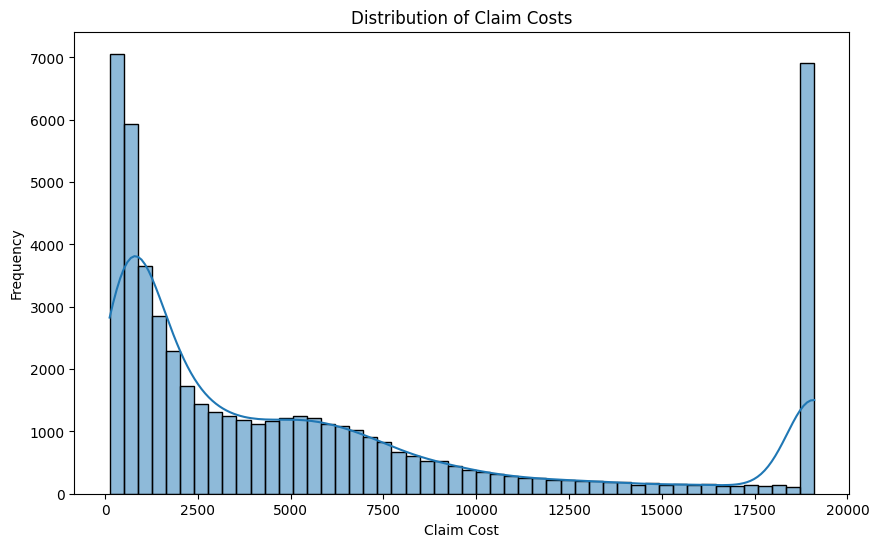

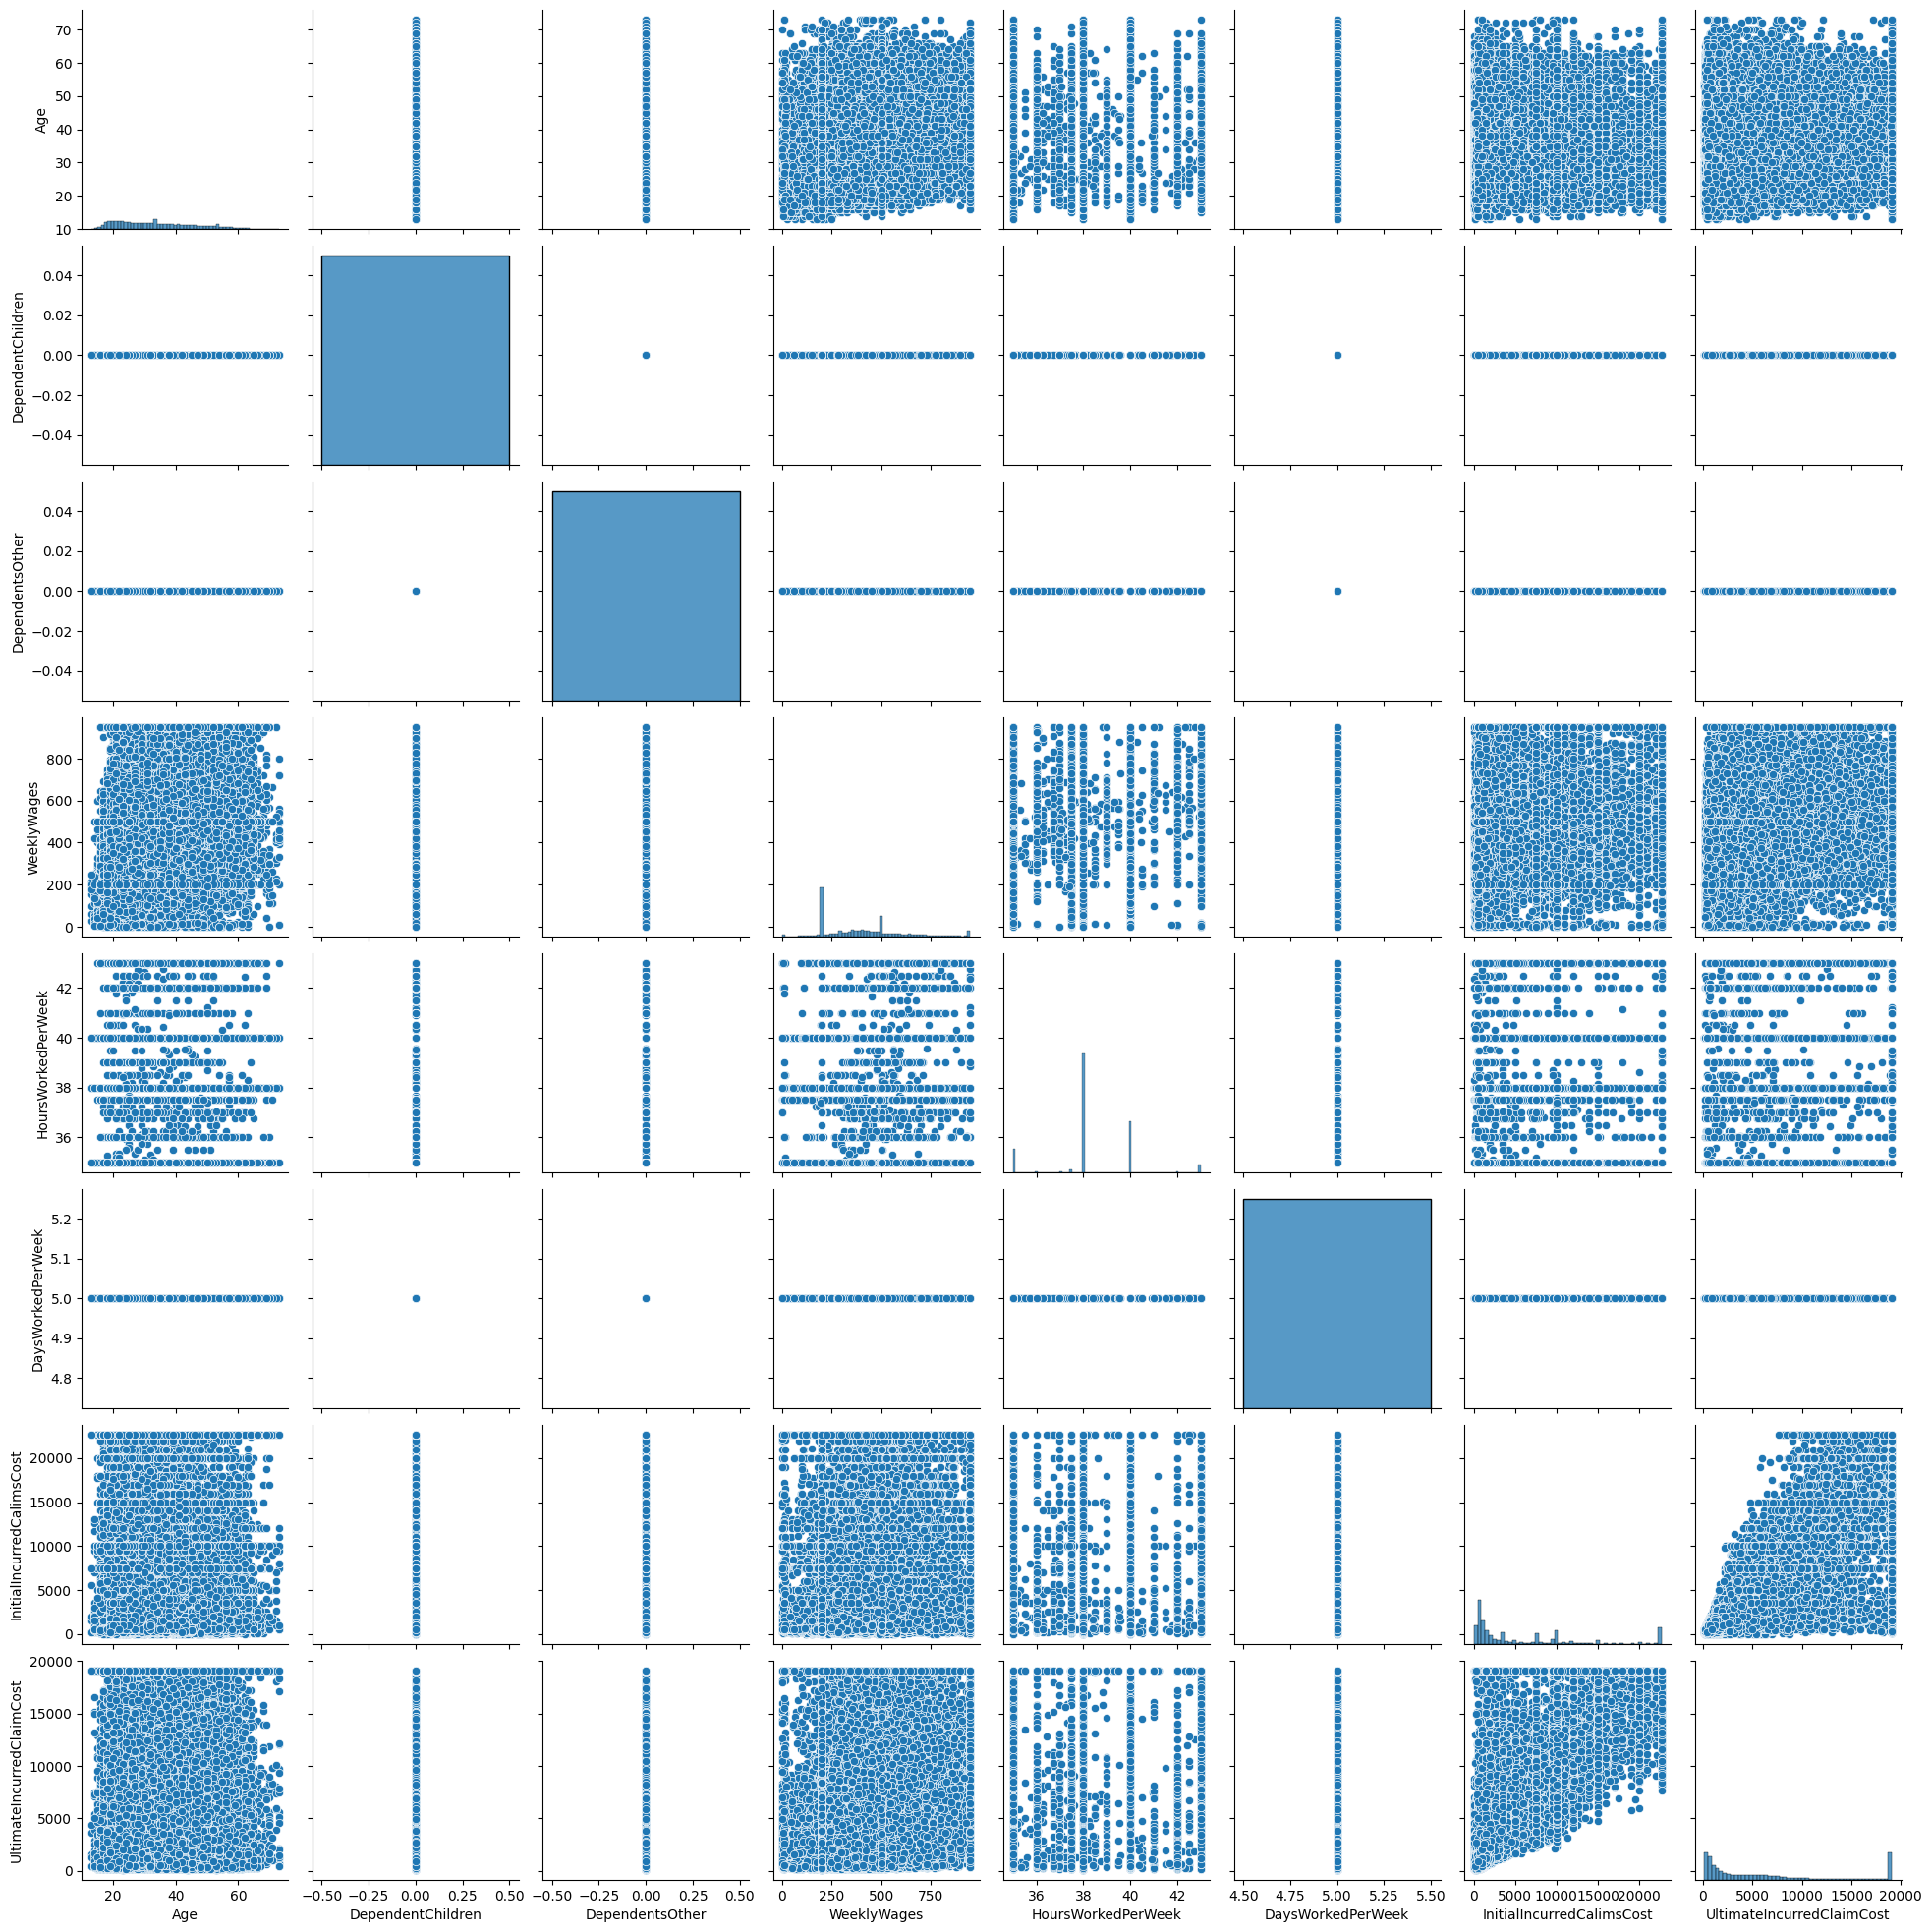

In [49]:
#quick visualization on the data

# Visualizing the distribution of the target variable
plt.figure(figsize=(10, 6))
sns.histplot(df['UltimateIncurredClaimCost'], kde=True)
plt.title('Distribution of Claim Costs')
plt.xlabel('Claim Cost')
plt.ylabel('Frequency')
plt.show()


# Pairplot to see relationships between variables
sns.pairplot(df[num_col])
plt.show()

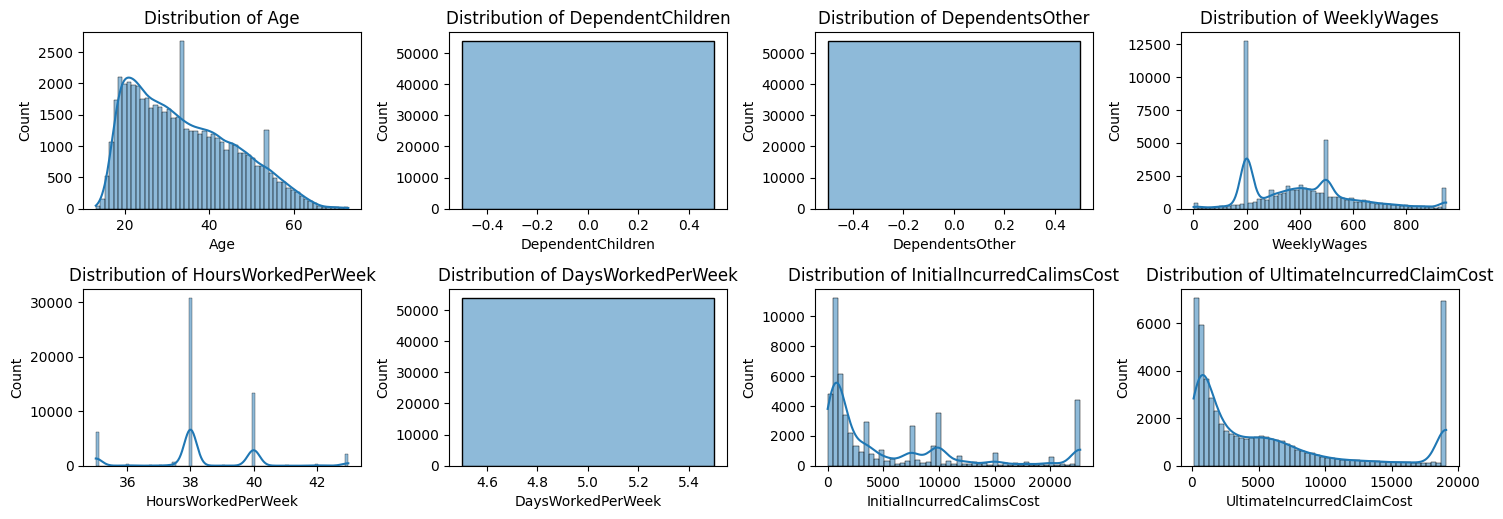

In [5]:
# visualize distributions of numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_col):
    plt.subplot(4, 4, i+1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()



In [ ]:
# visualize distributions of categorical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_col):
    plt.subplot(4, 4, i+1)
    sns.countplot(y=col, data=df)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

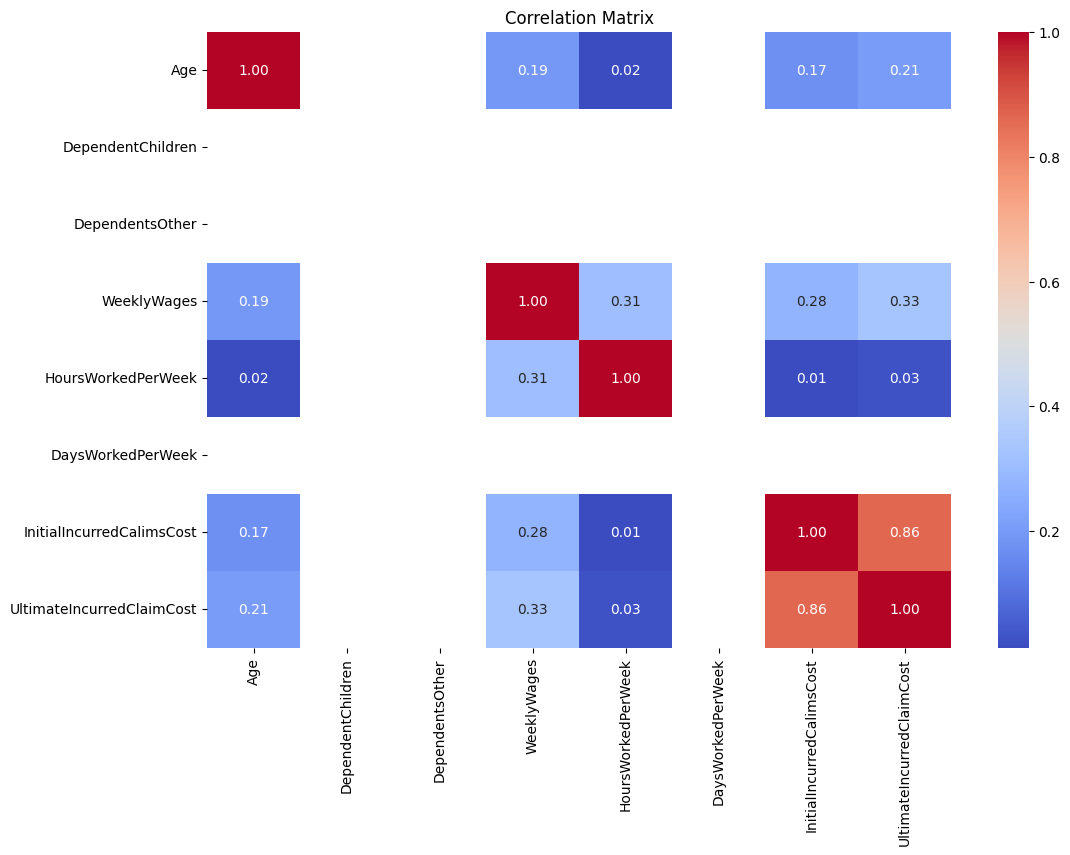

In [4]:
# Correlation matrix for numerical features
plt.figure(figsize=(12, 8))
corr_matrix = df[num_col].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

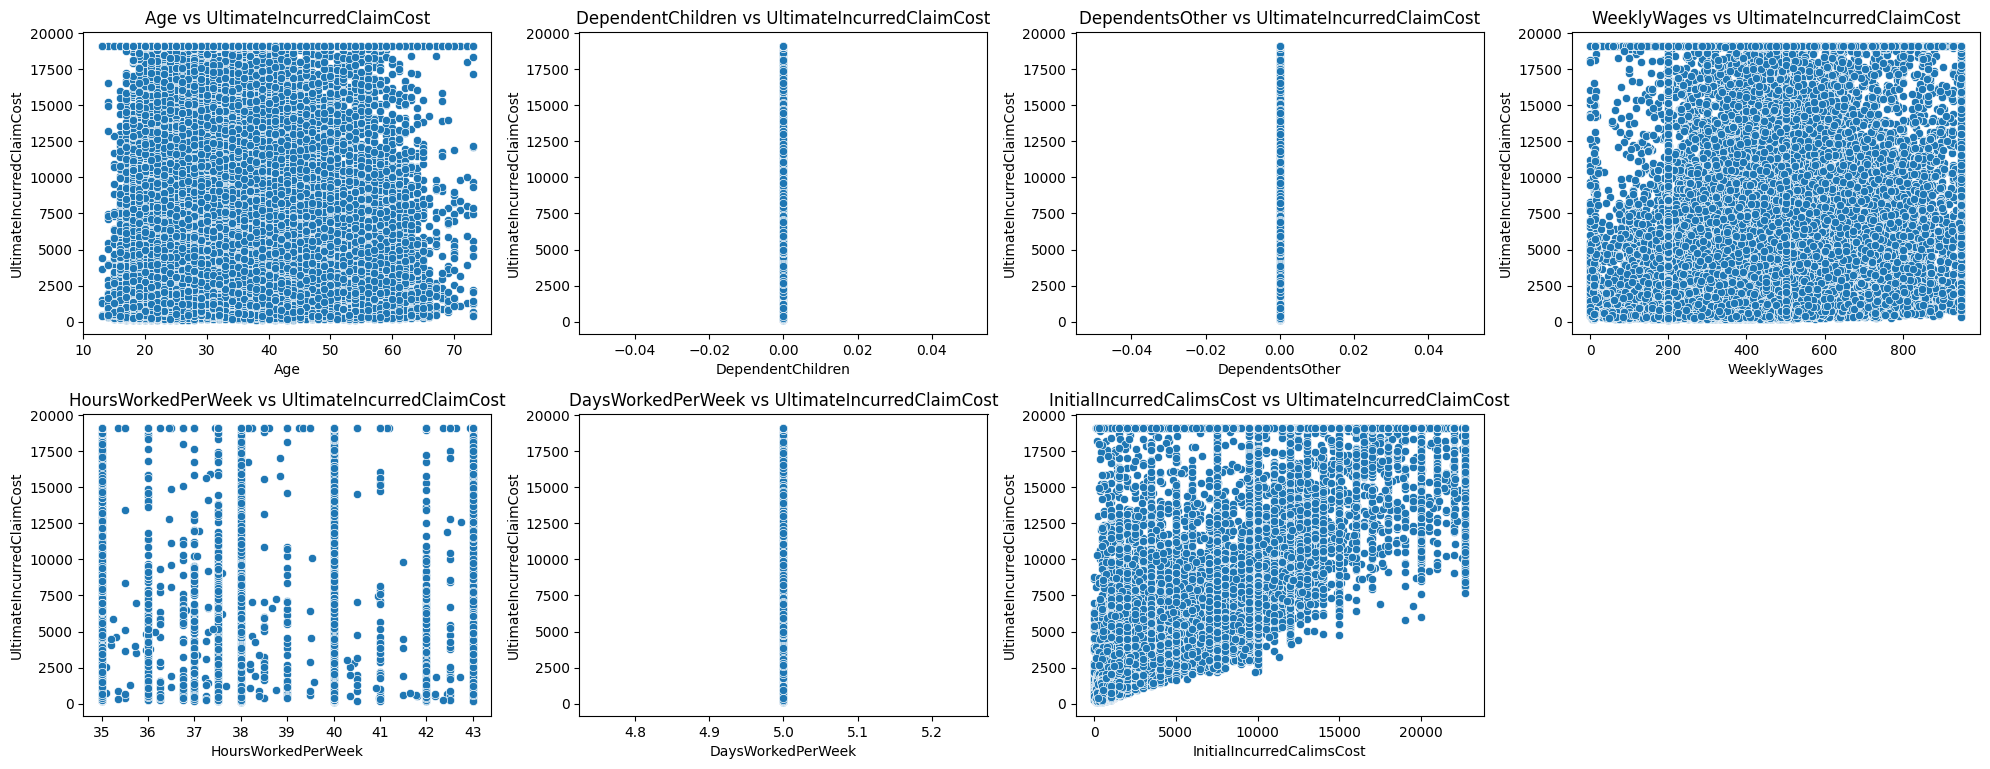

In [5]:
# Relationship between target variable and numerical features
plt.figure(figsize=(20, 15))
for i, col in enumerate(num_col.drop('UltimateIncurredClaimCost', errors='ignore')):
    plt.subplot(4, 4, i+1)
    sns.scatterplot(x=df[col], y=df['UltimateIncurredClaimCost'])
    plt.title(f'{col} vs UltimateIncurredClaimCost')
plt.tight_layout()
plt.show()


In [ ]:

# Relationship between target variable and categorical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(cat_col.drop('ClaimDescription','ClaimDescription')):
    plt.subplot(4, 4, i+1)
    sns.boxplot(x=col, y='UltimateIncurredClaimCost', data=df)
    plt.title(f'{col} vs UltimateIncurredClaimCost')
plt.tight_layout()
plt.show()

In [30]:
high = df[df['UltimateIncurredClaimCost'] > df['UltimateIncurredClaimCost'].median()]
low = df[df['UltimateIncurredClaimCost'] < df['UltimateIncurredClaimCost'].median()]
df['MaritalStatus'].value_counts().sort_index()

MaritalStatus
M    22516
S    26161
U     5294
Name: count, dtype: int64

## DEMO DISTRIB AND HIGH LOW DIS

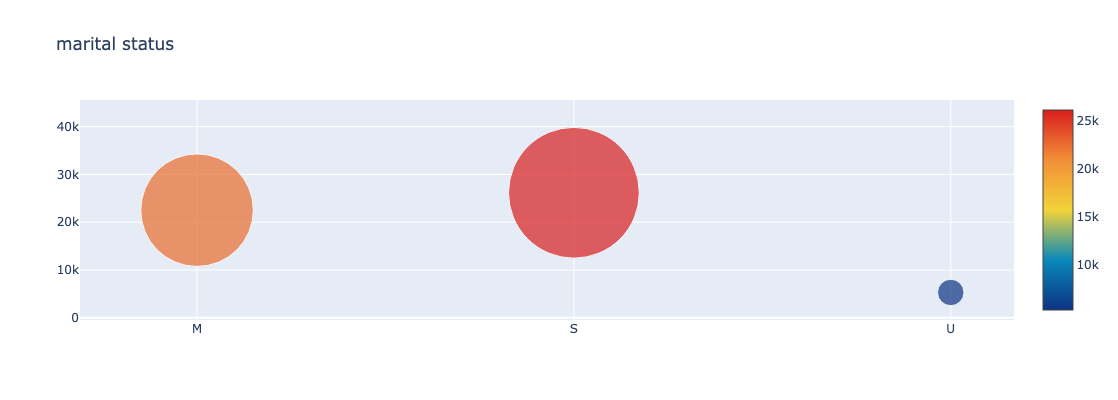

In [33]:
cnt_srs = df['MaritalStatus'].value_counts().sort_index()


trace = go.Scatter(
    x=cnt_srs.index,
    y=cnt_srs.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 2,
        size = (cnt_srs.values)/100,
        #color = np.random.randn(500), #set color equal to a variable
        color = cnt_srs.values,
        colorscale='Portland',
        showscale=True
    ),
)

layout = go.Layout(
    title='marital status', width=500, height=400
)

data1 = [trace]

fig = go.Figure(data=data1, layout=layout)

fig.show()
#py.iplot(fig, filename="Location")

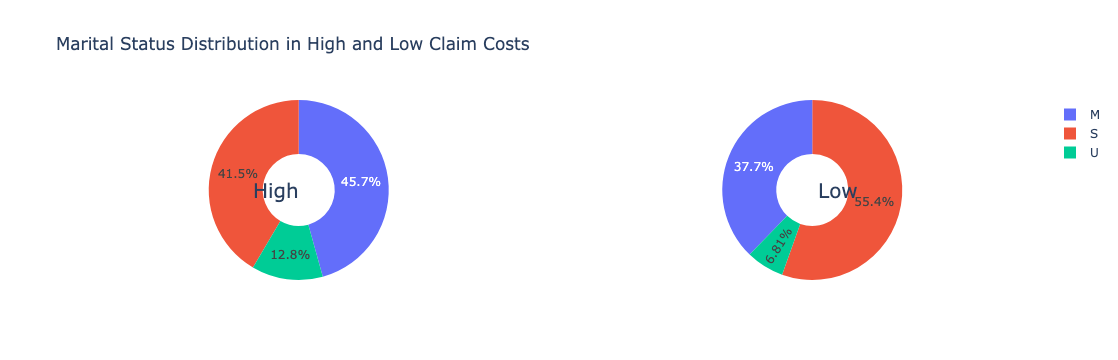

In [26]:

# Get value counts of MaritalStatus for high and low groups
high_counts = high['MaritalStatus'].value_counts().sort_index()
low_counts = low['MaritalStatus'].value_counts().sort_index()

colors = ['#636EFA', '#EF553B', '#00CC96']

# Create pie charts
pie_high = go.Pie(labels=high_counts.index, values=high_counts.values, name="High", hole=0.4, domain={'x': [0, 0.46]},marker=dict(colors=colors))
pie_low = go.Pie(labels=low_counts.index, values=low_counts.values, name="Low", hole=0.4, domain={'x': [0.54, 1]},marker=dict(colors=colors))

# Create the figure
fig = go.Figure(data=[pie_high, pie_low])

# Update layout
fig.update_layout(
    title_text="Marital Status Distribution in High and Low Claim Costs",
    annotations=[dict(text='High', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='Low', x=0.82, y=0.5, font_size=20, showarrow=False)]
)

# Show the figure
fig.show()

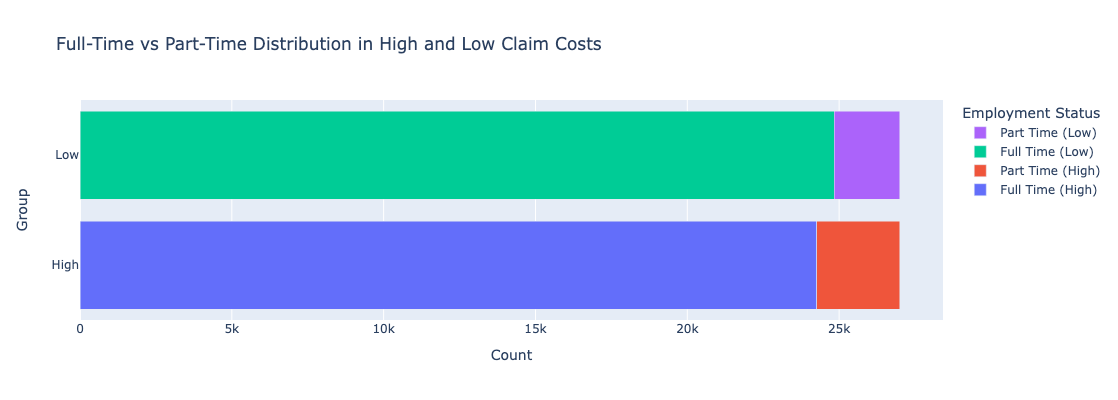

In [38]:
# Get value counts of PartTimeFullTime for high and low groups
high_counts = high['PartTimeFullTime'].value_counts().sort_index()
low_counts = low['PartTimeFullTime'].value_counts().sort_index()

# Align counts to categories
categories = high_counts.index.union(low_counts.index).tolist()
high_values = [high_counts.get(cat, 0) for cat in categories]
low_values = [low_counts.get(cat, 0) for cat in categories]

# Create traces for each category
trace_high_F = go.Bar(
    y=['High'],
    x=[high_values[0]],
    orientation='h',
    name='Full Time (High)',
    marker_color='#636EFA'
)
trace_high_P = go.Bar(
    y=['High'],
    x=[high_values[1]],
    orientation='h',
    name='Part Time (High)',
    marker_color='#EF553B'
)
trace_low_F = go.Bar(
    y=['Low'],
    x=[low_values[0]],
    orientation='h',
    name='Full Time (Low)',
    marker_color='#00CC96'
)
trace_low_P = go.Bar(
    y=['Low'],
    x=[low_values[1]],
    orientation='h',
    name='Part Time (Low)',
    marker_color='#AB63FA'
)

# Create the figure
fig = go.Figure(data=[trace_high_F, trace_high_P, trace_low_F, trace_low_P])

# Update layout for stacked bar chart
fig.update_layout(
    barmode='stack',
    title='Full-Time vs Part-Time Distribution in High and Low Claim Costs',
    xaxis_title='Count',
    yaxis_title='Group',
    width=800,
    height=400,
    legend_title='Employment Status'
)

# Show the figure
fig.show()

In [47]:
df5['AgeGroup'].value_counts().sum()

53932

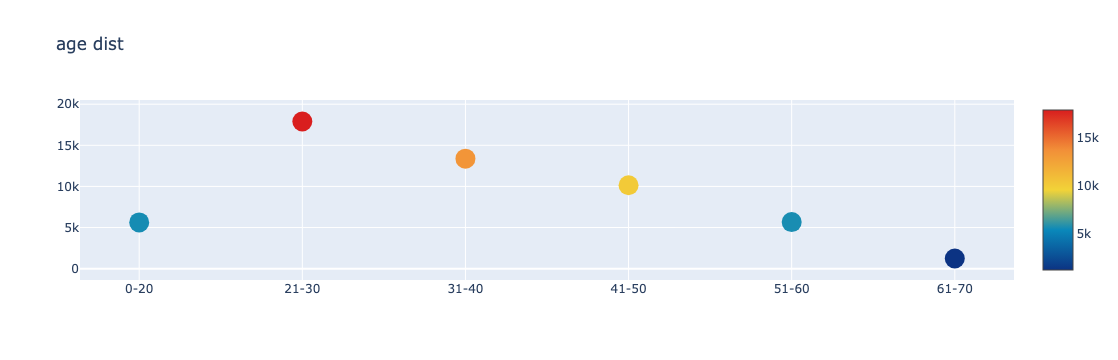

In [48]:
df5 = df.copy()



# Create bins for Age
bins = [0, 20, 30, 40, 50, 60, 70]
labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '61-70']
df5['AgeGroup'] = pd.cut(df5['Age'], bins=bins, labels=labels, right=False)

sorted_20 = df5['AgeGroup'].value_counts().sort_index()

trace = go.Scatter(
    x=sorted_20.index,
    y=sorted_20.values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 0.5,
        size = 20,
        #color = np.random.randn(500), #set color equal to a variable
        color = sorted_20.values,
        colorscale='Portland',
        showscale=True
    ),
)

layout = go.Layout(
    title='age dist'
)

data20 = [trace]
fig = go.Figure(data=data20, layout=layout)
fig.show()

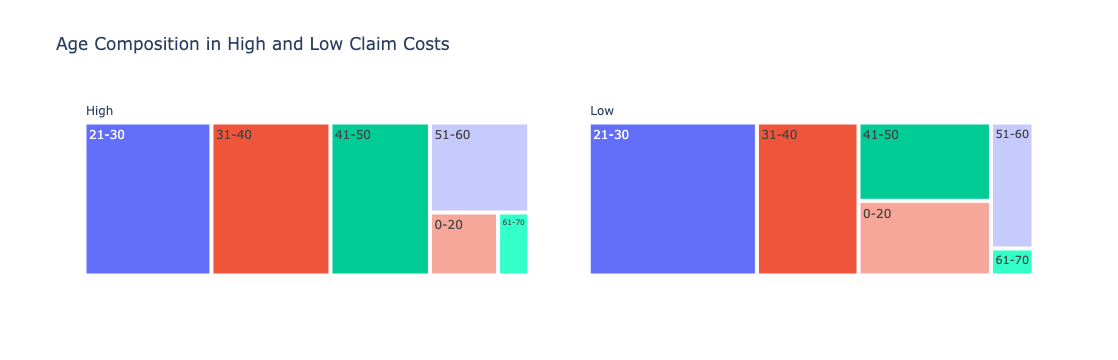

In [40]:


# Split the data again after creating bins
high1 = df5[df5['UltimateIncurredClaimCost'] > df5['UltimateIncurredClaimCost'].median()]
low1 = df5[df5['UltimateIncurredClaimCost'] <= df5['UltimateIncurredClaimCost'].median()]


# Get value counts of AgeGroup for high and low groups
high_counts = high1['AgeGroup'].value_counts().sort_index()
low_counts = low1['AgeGroup'].value_counts().sort_index()

# Create treemaps
fig = go.Figure()

# Treemap for high group
fig.add_trace(go.Treemap(
    labels=high_counts.index,
    parents=['High']*len(high_counts),
    values=high_counts.values,
    name="High",
    domain=dict(column=0)
))

# Treemap for low group
fig.add_trace(go.Treemap(
    labels=low_counts.index,
    parents=['Low']*len(low_counts),
    values=low_counts.values,
    name="Low",
    domain=dict(column=1)
))

# Update layout for side-by-side treemaps
fig.update_layout(
    title='Age Composition in High and Low Claim Costs',
    grid=dict(columns=2, rows=1),
    treemapcolorway=['#636EFA', '#EF553B', '#00CC96']
)

# Show the figure
fig.show()

# model building prep

# REGRESSION 

In [43]:
#we are going to leave out the open ended for now
df1 = df.drop(columns = ['ClaimDescription','ClaimNumber'])

#seperate target and features
X = df1.drop(columns='UltimateIncurredClaimCost')
y = df1['UltimateIncurredClaimCost']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [47]:
#post train test split cleaning

#redefine num and cat features with only X

num_f = X.select_dtypes(include= ['int32', 'float32']).columns
cat_f = X.select_dtypes(include= ['category']).columns

In [51]:
len(cat_f)

3

### CHEKCING NORMALITY SEE WHICH SCALR TO USE 

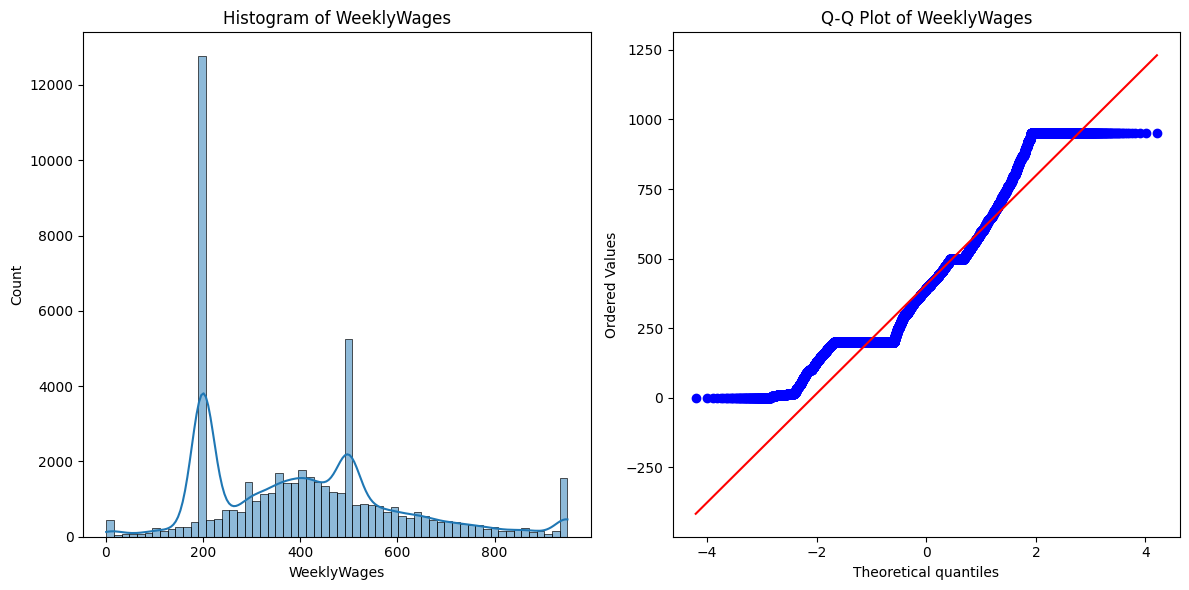

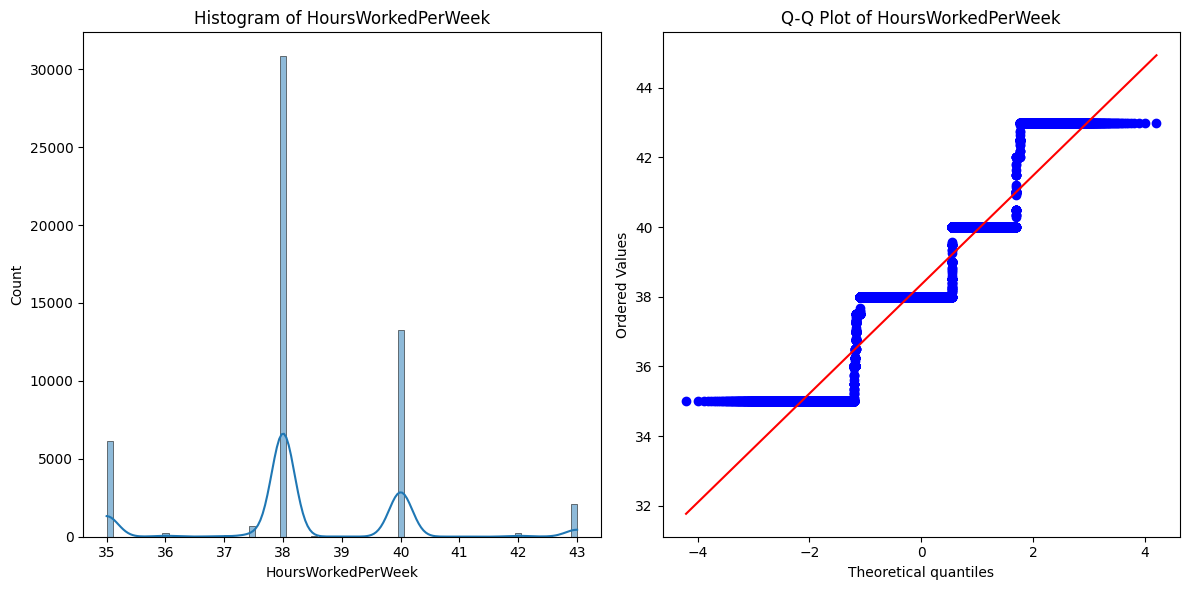

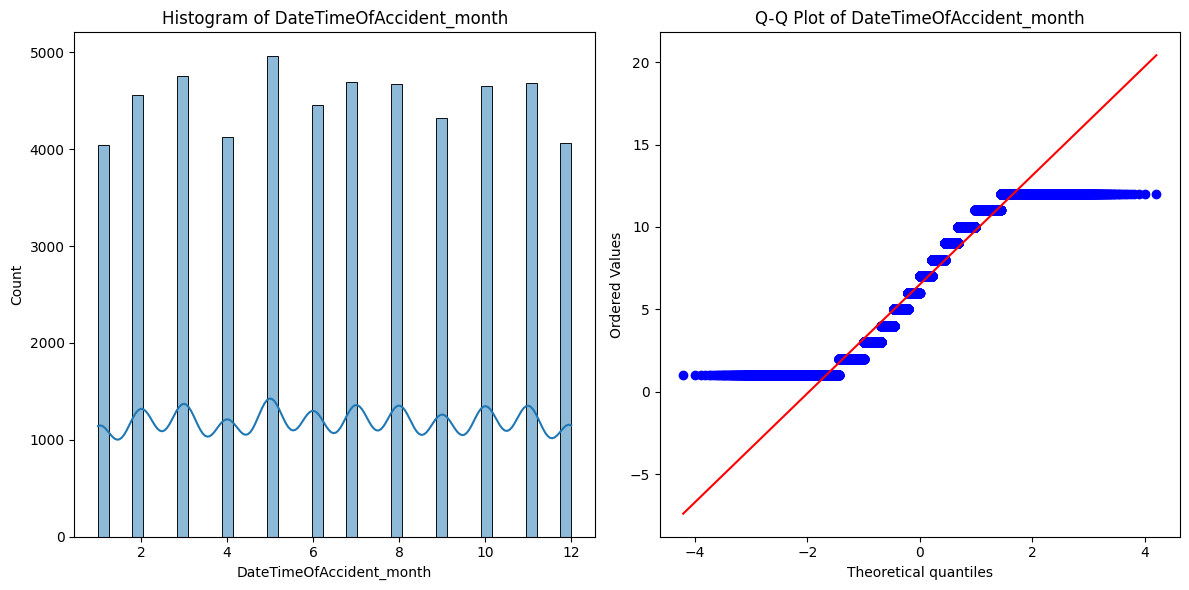

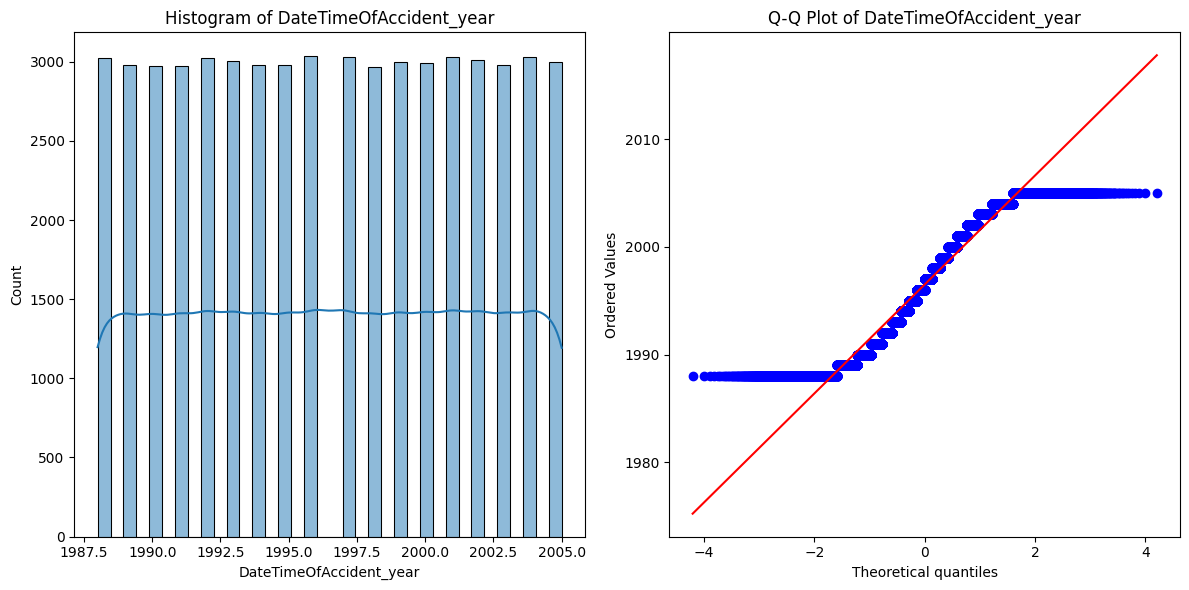

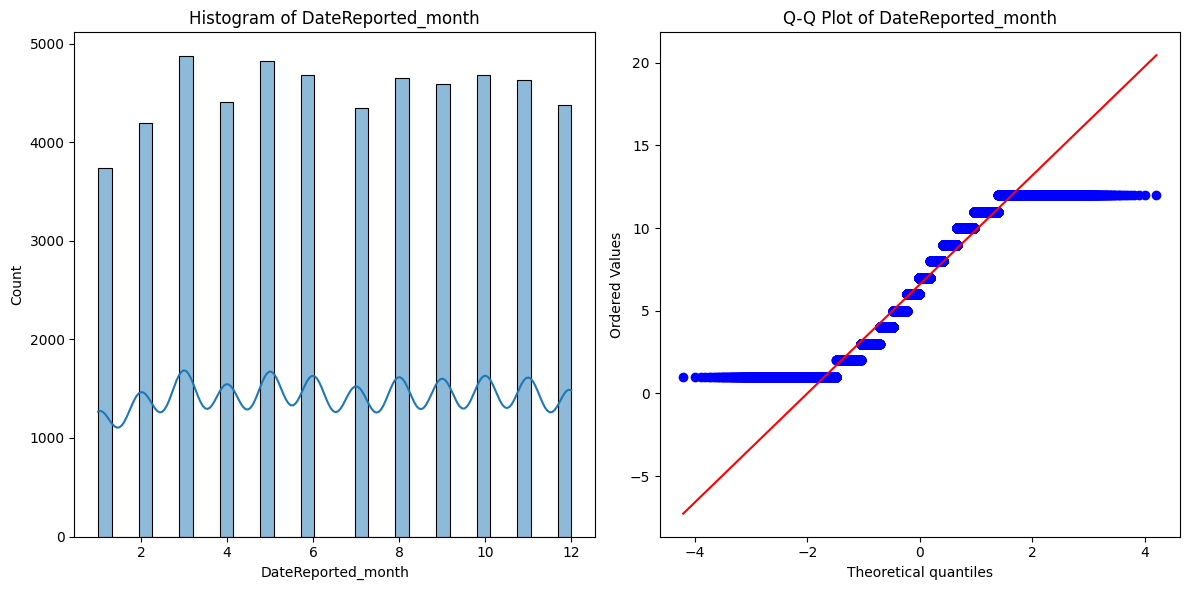

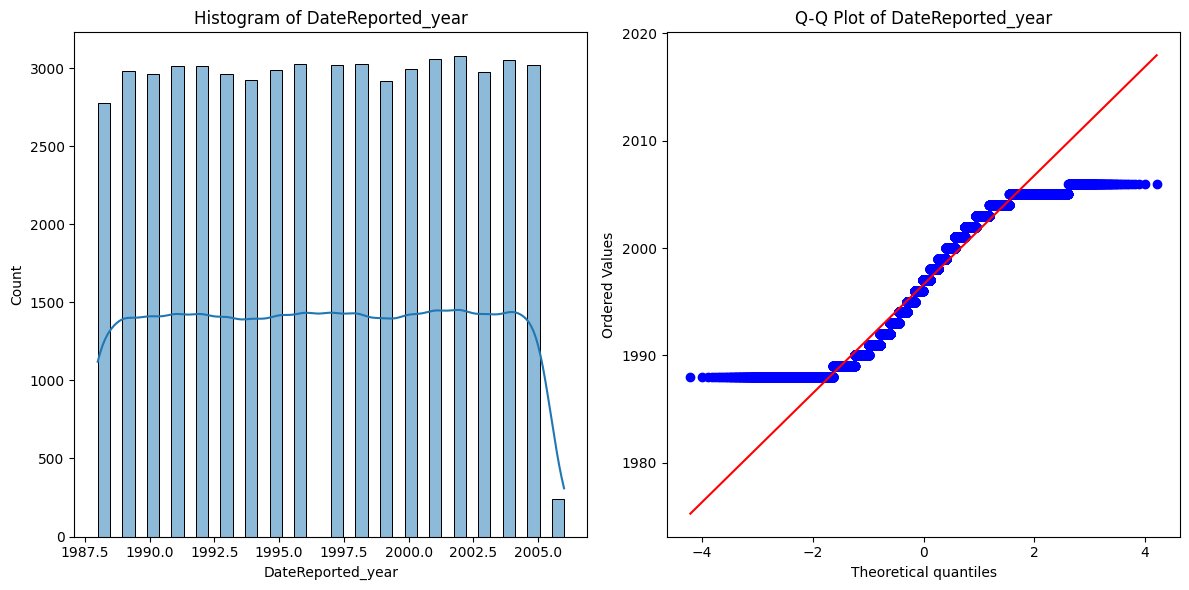

In [12]:
#grpahing for normality test
for column in num_f:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(X[column], kde=True)
    plt.title(f'Histogram of {column}')

    plt.subplot(1, 2, 2)
    stats.probplot(X[column], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {column}')

    plt.tight_layout()
    plt.show()

In [13]:
# Perform Shapiro-Wilk test and Kolmogorov-Smirnov test for each column
results = []
for column in num_f:
    shapiro_stat, shapiro_p_value = stats.shapiro(X[column])
    ks_stat, ks_p_value = stats.kstest(X[column], 'norm')
    results.append({
        'Column': column,
        'Shapiro-Wilk Test Statistic': shapiro_stat,
        'Shapiro-Wilk p-value': shapiro_p_value,
        'Kolmogorov-Smirnov Test Statistic': ks_stat,
        'Kolmogorov-Smirnov p-value': ks_p_value
    })

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results)
print(results_df)

                     Column  Shapiro-Wilk Test Statistic  \
0               WeeklyWages                     0.933133   
1        HoursWorkedPerWeek                     0.818378   
2  DateTimeOfAccident_month                     0.943695   
3   DateTimeOfAccident_year                     0.948428   
4        DateReported_month                     0.944320   
5         DateReported_year                     0.949875   

   Shapiro-Wilk p-value  Kolmogorov-Smirnov Test Statistic  \
0                   0.0                           0.997665   
1                   0.0                           1.000000   
2                   0.0                           0.902305   
3                   0.0                           1.000000   
4                   0.0                           0.908046   
5                   0.0                           1.000000   

   Kolmogorov-Smirnov p-value  
0                         0.0  
1                         0.0  
2                         0.0  
3               

In [52]:
#define preprocessing pipeline
num_trans = Pipeline(steps=[('imputer', SimpleImputer(strategy= 'median')), ('scaler', RobustScaler())])
cat_trans = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent')), ('encoder', OneHotEncoder(handle_unknown = 'ignore',drop = 'first'))])

# combine preprocessing pipelines
preprocessor = ColumnTransformer(transformers=[('num', num_trans, num_f),('cat', cat_trans, cat_f)])


# fit and transform the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# transform the test data
X_test_preprocessed = preprocessor.transform(X_test)


In [55]:
len(y_train)

36180

In [83]:
# function to calculate VIF
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

# convert the sparse matrix to a dense array
#X_train_preprocessed_dense = X_train_preprocessed.toarray()

# get feature names
feature_names = preprocessor.get_feature_names_out()

# convert preprocessed training data to DataFrame for VIF calculation
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names)

X_train_preprocessed_df

num__WeeklyWages  num__HoursWorkedPerWeek  \
0              0.422333                     0.00   
1             -1.268233                    -1.00   
2              0.318467                     1.00   
3             -0.640000                     0.00   
4             -0.307067                    -1.50   
...                 ...                      ...   
36175         -0.035667                     0.00   
36176         -0.140000                    -0.25   
36177          0.541833                     1.00   
36178         -0.640000                     0.00   
36179         -0.225000                    -1.50   

       num__DateTimeOfAccident_month  num__DateTimeOfAccident_year  \
0                                0.4                     -0.555556   
1                                0.2                      0.111111   
2                                0.4                      0.666667   
3                               -0.6                      0.222222   
4                                0.0                      0.555556   
...                              ...                           ...   
36175                            0.4                     -0.222222   
36176                            0.0                     -1.000000   
36177                           -0.4                     -0.888889   
36178                            0.8                      0.444444   
36179                            0.6                      0.666667   

       num__DateReported_month  num__DateReported_year  cat__Gender_M  \
0                     0.333333               -0.555556            1.0   
1                     0.166667                0.111111            1.0   
2                     0.333333                0.666667            1.0   
3                     0.000000                0.222222            1.0   
4                     0.166667                0.555556            0.0   
...                        ...                     ...            ...   
36175                 0.500000               -0.222222            1.0   
36176                 0.000000               -1.000000            0.0   
36177                -0.333333               -0.888889            1.0   
36178                 0.666667                0.444444            1.0   
36179                 0.666667                0.666667            1.0   

       cat__Gender_U  cat__MaritalStatus_S  cat__MaritalStatus_U  \
0                0.0                   0.0                   0.0   
1                0.0                   0.0                   1.0   
2                0.0                   0.0                   0.0   
3                0.0                   1.0                   0.0   
4                0.0                   1.0                   0.0   
...              ...                   ...                   ...   
36175            0.0                   0.0                   0.0   
36176            0.0                   0.0                   0.0   
36177            0.0                   0.0                   0.0   
36178            0.0                   1.0                   0.0   
36179            0.0                   0.0                   0.0   

       cat__PartTimeFullTime_P  
0                          0.0  
1                          0.0  
2                          0.0  
3                          0.0  
4                          1.0  
...                        ...  
36175                      0.0  
36176                      0.0  
36177                      0.0  
36178                      0.0  
36179                      1.0  

[36180 rows x 11 columns]

In [84]:
# VIF calc and reomval 
vif_data = calculate_vif(X_train_preprocessed_df)
print(vif_data)

                          feature         VIF
0                num__WeeklyWages    1.268805
1         num__HoursWorkedPerWeek    1.536017
2   num__DateTimeOfAccident_month    4.273705
3    num__DateTimeOfAccident_year  886.545108
4         num__DateReported_month    4.315514
5          num__DateReported_year  887.797113
6                   cat__Gender_M    2.221747
7                   cat__Gender_U    1.000232
8            cat__MaritalStatus_S    1.845423
9            cat__MaritalStatus_U    1.171124
10        cat__PartTimeFullTime_P    1.422330


In [85]:
#makes sense there is a high corr bw accident year and report year 
X_train_vif = X_train_preprocessed_df.drop(columns = 'num__DateTimeOfAccident_year')

In [86]:
#recalc vif after removing one of the correlated feature
vif_data = calculate_vif(X_train_vif)
print(vif_data)
# no more multicollinearity anymore since all vif < 5

                         feature       VIF
0               num__WeeklyWages  1.267272
1        num__HoursWorkedPerWeek  1.535332
2  num__DateTimeOfAccident_month  1.575042
3        num__DateReported_month  1.564790
4         num__DateReported_year  1.145268
5                  cat__Gender_M  2.085806
6                  cat__Gender_U  1.000168
7           cat__MaritalStatus_S  1.817992
8           cat__MaritalStatus_U  1.168870
9        cat__PartTimeFullTime_P  1.409902


In [87]:
#apply the same for test sset
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)
X_test_vif = X_test_preprocessed_df.drop(columns = 'num__DateTimeOfAccident_year')


### TRYING TO USE RIDGE 

In [95]:
estimator = Ridge()
rfe = RFE(estimator, n_features_to_select=6, step=1)
X_train_rfe = rfe.fit_transform(X_train_vif, y_train)
selected_rfe_features = X_train_vif.columns[rfe.support_]
selected_rfe_features


Index(['num__WeeklyWages', 'num__DateReported_year', 'cat__Gender_M',
       'cat__Gender_U', 'cat__MaritalStatus_S', 'cat__PartTimeFullTime_P'],
      dtype='object')

In [91]:
#apply the same transformation to the test set
X_test_rfe = X_test_vif[selected_rfe_features]

In [97]:
# Perform feature selection using F-test and selecting by p-value
f_values, p_values = f_regression(X_train_rfe, y_train)
p_value_threshold = 0.05
selected_features_f_test = selected_rfe_features[np.where(p_values < p_value_threshold)]
X_train_f_test =  X_train_vif[selected_features_f_test]

# apply the same transformations to the test set
X_test_f_test = X_test_vif[selected_features_f_test]

In [98]:
X_train_f_test

num__WeeklyWages  num__DateReported_year  cat__Gender_M  \
0              0.422333               -0.555556            1.0   
1             -1.268233                0.111111            1.0   
2              0.318467                0.666667            1.0   
3             -0.640000                0.222222            1.0   
4             -0.307067                0.555556            0.0   
...                 ...                     ...            ...   
36175         -0.035667               -0.222222            1.0   
36176         -0.140000               -1.000000            0.0   
36177          0.541833               -0.888889            1.0   
36178         -0.640000                0.444444            1.0   
36179         -0.225000                0.666667            1.0   

       cat__MaritalStatus_S  cat__PartTimeFullTime_P  
0                       0.0                      0.0  
1                       0.0                      0.0  
2                       0.0                      0.0  
3                       1.0                      0.0  
4                       1.0                      1.0  
...                     ...                      ...  
36175                   0.0                      0.0  
36176                   0.0                      0.0  
36177                   0.0                      0.0  
36178                   1.0                      0.0  
36179                   0.0                      1.0  

[36180 rows x 5 columns]

#### CHEKCING LINEAR 

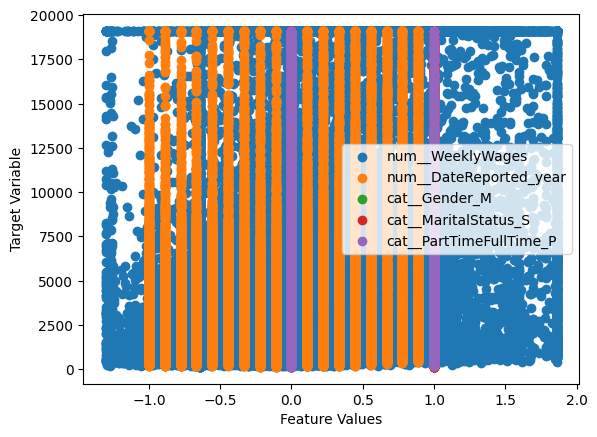

In [99]:
#scatter plot to see if the relationships are linear
for feature in X_train_f_test.columns:
    plt.scatter(X_train_f_test[feature], y_train, label=feature)
plt.xlabel('Feature Values')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

In [100]:
#another way to check to see if the relationships are linear
correlation_matrix = X_train_f_test.corrwith(y_train)
print(correlation_matrix)

num__WeeklyWages           0.000040
num__DateReported_year    -0.006406
cat__Gender_M             -0.010491
cat__MaritalStatus_S      -0.006252
cat__PartTimeFullTime_P    0.001251
dtype: float64


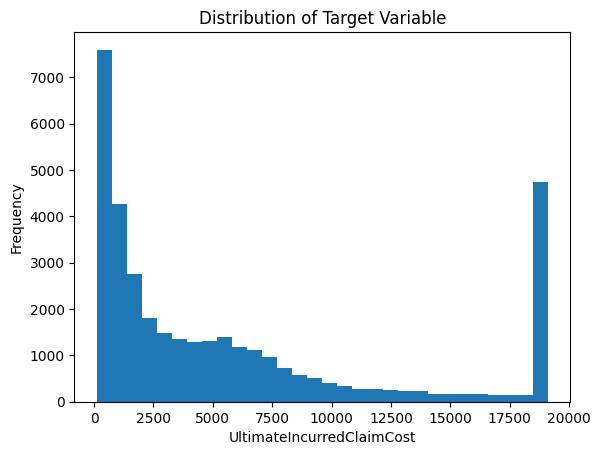

In [101]:
#need to transform data again so we could try ridge before using any other non linear models 

# Check the distribution of the target variable for skewness 
plt.hist(y_train, bins=30)
plt.xlabel('UltimateIncurredClaimCost')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.show()

#target data highly skewed

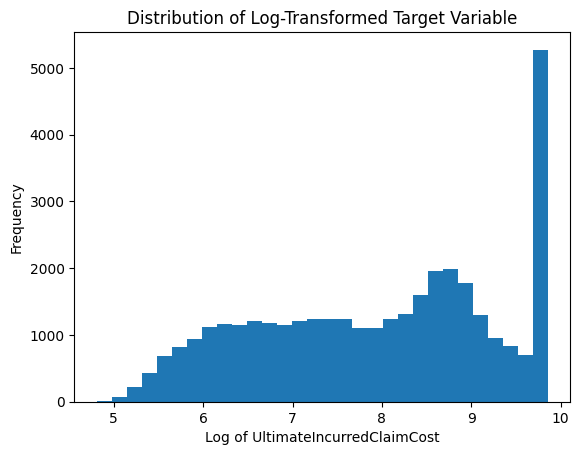

In [102]:
# log transform the target variable
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Check the distribution of the log-transformed target variable
plt.hist(y_train_log, bins=30)
plt.xlabel('Log of UltimateIncurredClaimCost')
plt.ylabel('Frequency')
plt.title('Distribution of Log-Transformed Target Variable')
plt.show()



In [104]:
# create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_f_test)
X_test_poly = poly.transform(X_test_f_test)

# standardize the polynomial features
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

## model building (regression)

### RIDGE REG WITH LOG AND POLY TRANSFORAMTION 

In [107]:
# we did initialize ridge earlier and now hyperparameter tuning and model building
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(estimator, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_poly_scaled, y_train_log)

# get the best model from grid search
best_model = grid_search.best_estimator_

# make predictions then reverse log
y_pred_log = best_model.predict(X_test_poly_scaled)
y_pred = np.expm1(y_pred_log)

# evaluate the model
mse_ridge = mean_squared_error(y_test, y_pred)
r2_ridge = r2_score(y_test, y_pred)
print(f'Ridge Regression - Mean Squared Error: {mse_ridge}')
print(f'Ridge Regression - R^2 Score: {r2_ridge}')


Ridge Regression - Mean Squared Error: 38376982.18401958
Ridge Regression - R^2 Score: 0.01860209600021545


### RF REGRES

In [110]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#ridge did not perform well even with grid search , so lets try non linear models instead 
#rf regressor grid search 
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train_f_test, y_train)

# Best parameters and model
best_rf = grid_search_rf.best_estimator_
print(f'Best Random Forest Model: {best_rf}')

# Evaluate the best model
y_pred_best_rf = best_rf.predict(X_test_f_test)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)
print(f'Best Random Forest Regressor - Mean Squared Error: {mse_best_rf}')
print(f'Best Random Forest Regressor - R^2 Score: {r2_best_rf}')

Best Random Forest Model: RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=200)
Best Random Forest Regressor - Mean Squared Error: 29700884.316203337
Best Random Forest Regressor - R^2 Score: 0.24047218004026372


In [ ]:
#the one without grid search optimization 
############TO SVAE TIME 

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_f_test, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test_f_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'Random Forest Regressor - Mean Squared Error: {mse_rf}')
print(f'Random Forest Regressor - R^2 Score: {r2_rf}')

In [116]:
#rf w gridsearch still didn't perform well, lets try it with the polynomial which is further feature engineering and see if it will improve 

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, scoring='r2', n_jobs=-1)
grid_search_rf.fit(X_train_poly_scaled, y_train)

# Best parameters and model
best_rf = grid_search_rf.best_estimator_
print(f'Best Random Forest Model: {best_rf}')

# Evaluate the best model
y_pred_best_rf = best_rf.predict(X_test_poly_scaled)
mse_best_rf = mean_squared_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)
print(f'Best Random Forest Regressor - Mean Squared Error: {mse_best_rf}')
print(f'Best Random Forest Regressor - R^2 Score: {r2_best_rf}')

Best Random Forest Model: RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=10, n_estimators=200)
Best Random Forest Regressor - Mean Squared Error: 29684684.634891346
Best Random Forest Regressor - R^2 Score: 0.24088644745735288


### GB REGRES

In [115]:
# Define the parameter grid
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Grid Search
grid_search_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, scoring='r2', n_jobs=-1)
grid_search_gb.fit(X_train_f_test, y_train)

# Best parameters and model
best_gb = grid_search_gb.best_estimator_
print(f'Best Gradient Boosting Model: {best_gb}')

# Evaluate the best model
y_pred_best_gb = best_gb.predict(X_test_f_test)
mse_best_gb = mean_squared_error(y_test, y_pred_best_gb)
r2_best_gb = r2_score(y_test, y_pred_best_gb)
print(f'Best Gradient Boosting Regressor - Mean Squared Error: {mse_best_gb}')
print(f'Best Gradient Boosting Regressor - R^2 Score: {r2_best_gb}')

Best Gradient Boosting Model: GradientBoostingRegressor(max_depth=4, min_samples_leaf=2, random_state=42)
Best Gradient Boosting Regressor - Mean Squared Error: 29603081.41918359
Best Gradient Boosting Regressor - R^2 Score: 0.24297325106455747


In [ ]:
#### SHORT VERSION OF GB 



# Initialize and fit the Gradient Boosting Regressor with default parameters
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train_f_test, y_train)

# Predict using the fitted model
y_pred_gb = gb_regressor.predict(X_test_f_test)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Gradient Boosting Regressor - Mean Squared Error: {mse_gb}')
print(f'Gradient Boosting Regressor - R^2 Score: {r2_gb}')

In [111]:
# Get feature importances from the Random Forest model
importances = best_rf.feature_importances_
feature_importances = pd.DataFrame({'feature': selected_features_f_test, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Print the top features
print("Feature Importances from Random Forest:")
print(feature_importances)

Feature Importances from Random Forest:
                   feature  importance
0         num__WeeklyWages    0.512646
1   num__DateReported_year    0.389731
3     cat__MaritalStatus_S    0.056586
2            cat__Gender_M    0.025759
4  cat__PartTimeFullTime_P    0.015278


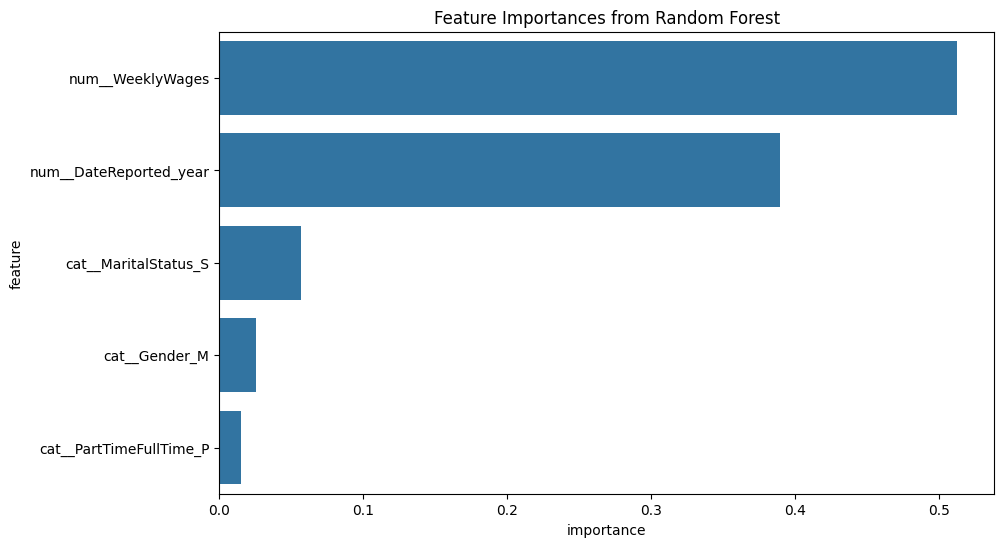

In [112]:
# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importances)
plt.title('Feature Importances from Random Forest')
plt.show()

## CLASSIFICATION 

highcost
1    0.5
0    0.5
Name: proportion, dtype: float64


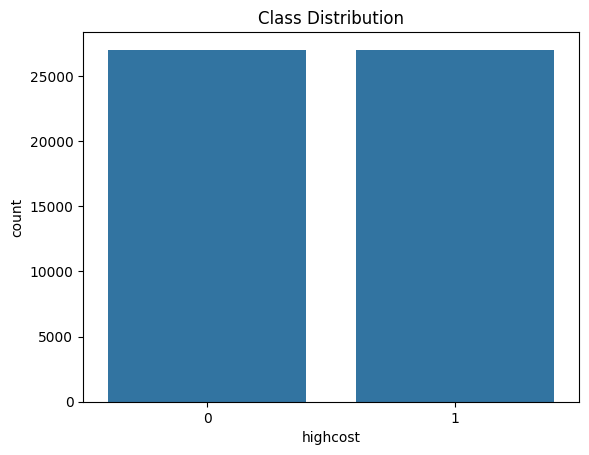

In [144]:
#similar to before, we are leaving out those 2 columns so they dont mess up our models
df2 = df.drop(columns = ['ClaimDescription','ClaimNumber'])

#now let's create a binary column 
threshold = df2['UltimateIncurredClaimCost'].median()
df2['highcost'] = (df2['UltimateIncurredClaimCost']>threshold).astype(int)

# check class balance
print(df2['highcost'].value_counts(normalize=True))

# plot the class distribution
sns.countplot(x='highcost', data=df2)
plt.title('Class Distribution')
plt.show()

## model building (classification) 

In [121]:


#similar process as before, create x y 
#seperate target and features
X_c = df2.drop(columns=['UltimateIncurredClaimCost', 'highcost'])
y_c = df2['highcost']

#train test split
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.33, random_state=42)

num_f_c = X_c.select_dtypes(include= ['int32', 'float32']).columns
cat_f_c = X_c.select_dtypes(include= ['category']).columns

# combine preprocessing pipelines
preprocessor_c = ColumnTransformer(transformers=[('num', num_trans, num_f_c),('cat', cat_trans, cat_f_c)])


# fit and transform the training data
X_train_preprocessed_c = preprocessor_c.fit_transform(X_train_c)

# transform the test data
X_test_preprocessed_c = preprocessor_c.transform(X_test_c)


In [122]:
# convert preprocessed training data to DataFrame for VIF calculation
X_train_preprocessed_df_c = pd.DataFrame(X_train_preprocessed_c, columns=preprocessor_c.get_feature_names_out())


# VIF calc and reomval 
vif_data_c = calculate_vif(X_train_preprocessed_df_c)
print(vif_data_c)

                          feature         VIF
0                num__WeeklyWages    1.268805
1         num__HoursWorkedPerWeek    1.536017
2   num__DateTimeOfAccident_month    4.273705
3    num__DateTimeOfAccident_year  886.545108
4         num__DateReported_month    4.315514
5          num__DateReported_year  887.797113
6                   cat__Gender_M    2.221747
7                   cat__Gender_U    1.000232
8            cat__MaritalStatus_S    1.845423
9            cat__MaritalStatus_U    1.171124
10        cat__PartTimeFullTime_P    1.422330


In [124]:
#makes sense there is a high corr bw accident year and report year 
X_train_vif_c = X_train_preprocessed_df_c.drop(columns = 'num__DateTimeOfAccident_year')
#recalc vif after removing one of the correlated feature
vif_data_c = calculate_vif(X_train_vif_c)
print(vif_data_c)
# no more multicollinearity anymore since all vif < 5

                         feature       VIF
0               num__WeeklyWages  1.267272
1        num__HoursWorkedPerWeek  1.535332
2  num__DateTimeOfAccident_month  1.575042
3        num__DateReported_month  1.564790
4         num__DateReported_year  1.145268
5                  cat__Gender_M  2.085806
6                  cat__Gender_U  1.000168
7           cat__MaritalStatus_S  1.817992
8           cat__MaritalStatus_U  1.168870
9        cat__PartTimeFullTime_P  1.409902


In [125]:
#apply the same for test sset
X_test_preprocessed_df_c = pd.DataFrame(X_test_preprocessed_c, columns=preprocessor_c.get_feature_names_out())
X_test_vif_c = X_test_preprocessed_df_c.drop(columns = 'num__DateTimeOfAccident_year')


### TRYING TO USE LOGISTIC 

In [131]:
#RFE for feature reduction - just with logistic as estimator now 

estimator_c = LogisticRegression(random_state=42, max_iter=1000)
rfe_c = RFE(estimator_c, n_features_to_select=8, step=1)
X_train_rfe_c = rfe_c.fit_transform(X_train_vif_c, y_train_c)
selected_rfe_features_c = X_train_vif_c.columns[rfe_c.support_]
selected_rfe_features_c

Index(['num__WeeklyWages', 'num__DateReported_month', 'num__DateReported_year',
       'cat__Gender_M', 'cat__Gender_U', 'cat__MaritalStatus_S',
       'cat__MaritalStatus_U', 'cat__PartTimeFullTime_P'],
      dtype='object')

In [132]:
#apply the same transformation to the test set
X_test_rfe_c = X_test_vif[selected_rfe_features_c]

In [133]:
X_test_rfe_c

num__WeeklyWages  num__DateReported_month  num__DateReported_year  \
0              0.360000                 0.833333                0.444444   
1              0.360000                 0.333333                0.555556   
2             -0.439733                 0.166667                0.888889   
3              0.104533                -0.500000                0.111111   
4              0.360000                 0.666667                0.777778   
...                 ...                      ...                     ...   
17815          0.360000                -0.833333                0.777778   
17816          1.390300                -0.666667                0.777778   
17817         -0.640000                 0.333333                0.333333   
17818         -0.640000                -0.166667                0.666667   
17819         -0.640000                -0.666667                0.555556   

       cat__Gender_M  cat__Gender_U  cat__MaritalStatus_S  \
0                1.0            0.0                   1.0   
1                1.0            0.0                   1.0   
2                0.0            0.0                   1.0   
3                1.0            0.0                   0.0   
4                1.0            0.0                   0.0   
...              ...            ...                   ...   
17815            1.0            0.0                   1.0   
17816            1.0            0.0                   1.0   
17817            1.0            0.0                   1.0   
17818            0.0            0.0                   1.0   
17819            1.0            0.0                   1.0   

       cat__MaritalStatus_U  cat__PartTimeFullTime_P  
0                       0.0                      0.0  
1                       0.0                      0.0  
2                       0.0                      0.0  
3                       0.0                      0.0  
4                       0.0                      0.0  
...                     ...                      ...  
17815                   0.0                      0.0  
17816                   0.0                      0.0  
17817                   0.0                      0.0  
17818                   0.0                      1.0  
17819                   0.0                      1.0  

[17820 rows x 8 columns]

In [136]:
# Perform feature selection using F-test and selecting by p-value
f_values_c, p_values_c = f_regression(X_train_rfe_c, y_train_c)
#printing out the f regression results
f_test_results = pd.DataFrame({'Feature': selected_rfe_features_c, 'F-Value': f_values_c, 'p-Value': p_values_c})
print(f_test_results)

p_value_threshold = 0.05
selected_features_f_test_c = selected_rfe_features_c[np.where(p_values_c < p_value_threshold)]
X_train_f_test_c =  X_train_vif_c[selected_features_f_test_c]

# apply the same transformations to the test set
X_test_f_test_c = X_test_rfe_c[selected_features_f_test_c]

                   Feature      F-Value        p-Value
0         num__WeeklyWages  2406.947935   0.000000e+00
1  num__DateReported_month     7.422650   6.443881e-03
2   num__DateReported_year  1196.007402  7.254445e-258
3            cat__Gender_M   203.227566   5.498357e-46
4            cat__Gender_U     1.003101   3.165681e-01
5     cat__MaritalStatus_S   696.605980  4.526682e-152
6     cat__MaritalStatus_U   324.026466   3.972148e-72
7  cat__PartTimeFullTime_P    63.848629   1.383110e-15


In [135]:
selected_features_f_test_c

Index(['num__WeeklyWages', 'num__DateReported_month', 'num__DateReported_year',
       'cat__Gender_M', 'cat__MaritalStatus_S', 'cat__MaritalStatus_U',
       'cat__PartTimeFullTime_P'],
      dtype='object')

### CHECKING LINEAR 

In [137]:
#another way to check to see if the relationships are linear
correlation_matrix_c = X_train_f_test_c.corrwith(y_train_c)
print(correlation_matrix_c)

#weekly wages:Correlation: -0.004625 (almost no linear relationship) 
#F-Value: 2406.947935 (very significant in the context of the regression model)

num__WeeklyWages          -0.004625
num__DateReported_month   -0.002603
num__DateReported_year    -0.000172
cat__Gender_M             -0.010712
cat__MaritalStatus_S       0.003951
cat__MaritalStatus_U       0.007234
cat__PartTimeFullTime_P    0.004725
dtype: float64


Logistic Regression - Accuracy: 0.6288
Confusion Matrix:
[[5853 3029]
 [3586 5352]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      8882
           1       0.64      0.60      0.62      8938

    accuracy                           0.63     17820
   macro avg       0.63      0.63      0.63     17820
weighted avg       0.63      0.63      0.63     17820



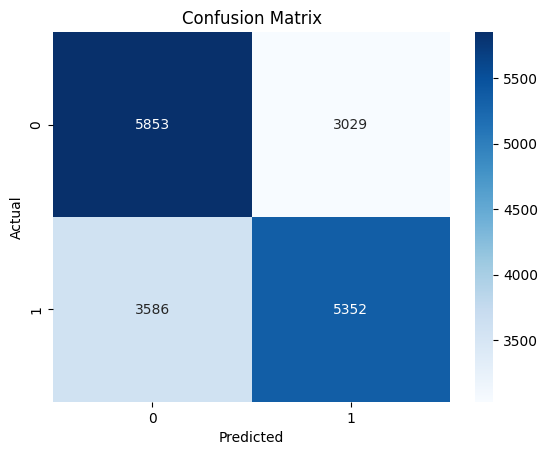

Feature Importances from Logistic Regression:
                   feature  importance
0         num__WeeklyWages    0.714773
2   num__DateReported_year    0.452830
6  cat__PartTimeFullTime_P    0.366166
5     cat__MaritalStatus_U    0.270322
1  num__DateReported_month    0.049327
3            cat__Gender_M   -0.431910
4     cat__MaritalStatus_S   -0.506391


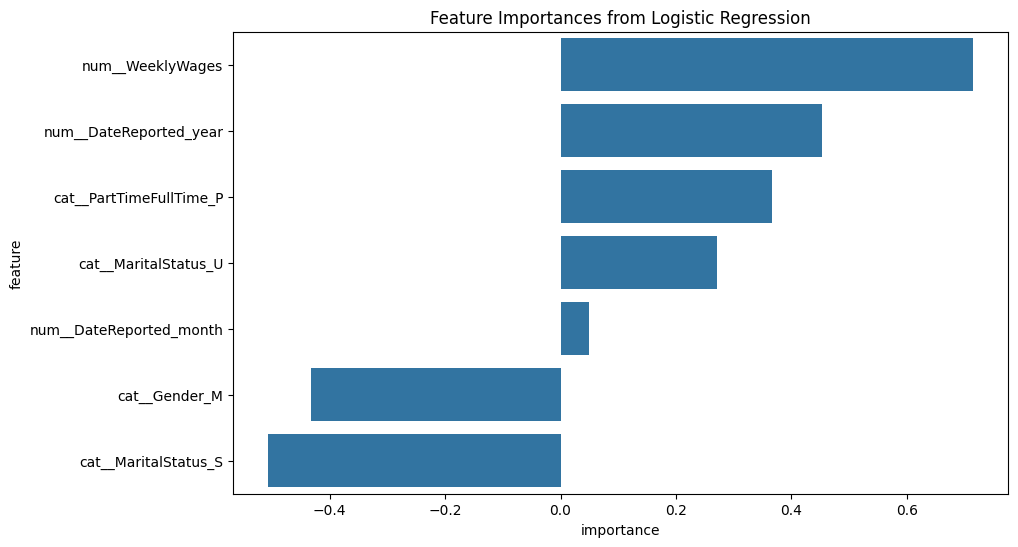

In [143]:
# train a Logistic Regression model
logreg_model = LogisticRegression(random_state=42, max_iter=1000)
logreg_model.fit(X_train_f_test_c , y_train_c)

# Make predictions on the test set
y_pred_log = logreg_model.predict(X_test_f_test_c )

# Evaluate the model
accuracy = accuracy_score(y_test_c, y_pred_log)
conf_matrix_log = confusion_matrix(y_test_c, y_pred_log)
class_report_log = classification_report(y_test_c, y_pred_log)

print(f"Logistic Regression - Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix_log)
print("Classification Report:")
print(class_report_log)

# Visualize the confusion matrix
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature importance
feature_importance_log = pd.DataFrame({'feature': selected_features_f_test_c, 'importance': logreg_model.coef_[0]})
feature_importance_log = feature_importance_log.sort_values(by='importance', ascending=False)
print("Feature Importances from Logistic Regression:")
print(feature_importance_log)

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_log)
plt.title('Feature Importances from Logistic Regression')
plt.show()

#male and single have lower possibility of high cost 

### transformation w log and poly

Logistic Regression with Polynomial Features - Accuracy: 0.6279
Confusion Matrix:
[[5990 2892]
 [3738 5200]]
Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.67      0.64      8882
           1       0.64      0.58      0.61      8938

    accuracy                           0.63     17820
   macro avg       0.63      0.63      0.63     17820
weighted avg       0.63      0.63      0.63     17820



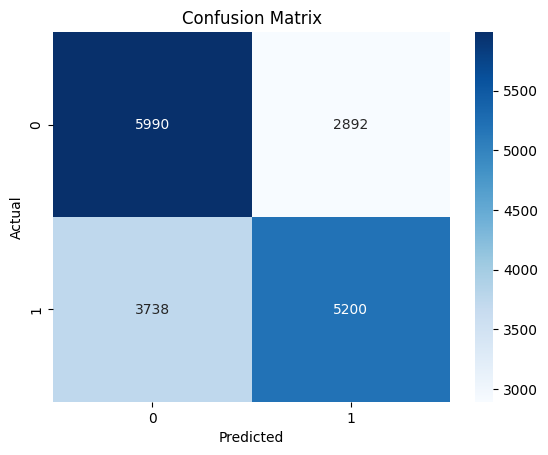

In [146]:
#the logistic regression performed ok, but since the dataset dosent have a strong linear relationship, 
#lets make adjustments to see if the performance could be optimized

#polyomical features 

# reate polynomial features (degree 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly_c = poly.fit_transform(X_train_f_test_c)
X_test_poly_c = poly.transform(X_test_f_test_c)

# Train a Logistic Regression model with polynomial features
logreg_model_poly = LogisticRegression(random_state=42, max_iter=1000)
logreg_model_poly.fit(X_train_poly_c, y_train_c)

# Make predictions on the test set
y_pred_poly_c = logreg_model_poly.predict(X_test_poly_c)

# Evaluate the model
accuracy_poly_c = accuracy_score(y_test_c, y_pred_poly_c)
conf_matrix_poly_c = confusion_matrix(y_test_c, y_pred_poly_c)
class_report_poly_c = classification_report(y_test_c, y_pred_poly_c)

print(f"Logistic Regression with Polynomial Features - Accuracy: {accuracy_poly_c:.4f}")
print("Confusion Matrix:")
print(conf_matrix_poly_c)
print("Classification Report:")
print(class_report_poly_c)

# Visualize the confusion matrix
sns.heatmap(conf_matrix_poly_c, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### rf class

In [149]:
# logsitic performance didnt really improve from adding polynomial feature, now lets try other models

from sklearn.ensemble import RandomForestClassifier

#parameter grid for rf
rf_param_grid_c = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize GridSearchCV
rf_model_c = RandomForestClassifier(random_state=42)
rf_grid_search_c = GridSearchCV(estimator=rf_model_c , param_grid=rf_param_grid_c, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
rf_grid_search_c.fit(X_train_f_test_c, y_train_c)

# Get the best models
best_rf_model_c = rf_grid_search_c.best_estimator_

# Make predictions
y_pred_rf_c = best_rf_model_c.predict(X_test_f_test_c)

# evaluate the model
accuracy_rf_c = accuracy_score(y_test_c, y_pred_rf_c)
conf_matrix_rf_c = confusion_matrix(y_test_c, y_pred_rf_c)
class_report_rf_c = classification_report(y_test_c, y_pred_rf_c)

print(f"Random Forest - Accuracy: {accuracy_rf_c:.4f}")
print("Confusion Matrix:")
print(conf_matrix_rf_c)
print("Classification Report:")
print(class_report_rf_c)

# Visualize the confusion matrix
sns.heatmap(conf_matrix_rf_c, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

NameError: name 'best_rf_model_c' is not defined

In [ ]:
#### SHORT VERSION 


# Initialize and fit the Random Forest Classifier with default parameters
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_f_test_c, y_train_c)

# Make predictions
y_pred_rf_c = rf_classifier.predict(X_test_f_test_c)

# Evaluate the model
accuracy_rf_c = accuracy_score(y_test_c, y_pred_rf_c)
conf_matrix_rf_c = confusion_matrix(y_test_c, y_pred_rf_c)
class_report_rf_c = classification_report(y_test_c, y_pred_rf_c)

print(f"Random Forest - Accuracy: {accuracy_rf_c:.4f}")
print("Confusion Matrix:")
print(conf_matrix_rf_c)
print("Classification Report:")
print(class_report_rf_c)

# Visualize the confusion matrix
sns.heatmap(conf_matrix_rf_c, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### gb class

Gradient Boosting - Accuracy: 0.6661
Confusion Matrix:
[[6501 2381]
 [3569 5369]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.73      0.69      8882
           1       0.69      0.60      0.64      8938

    accuracy                           0.67     17820
   macro avg       0.67      0.67      0.66     17820
weighted avg       0.67      0.67      0.66     17820



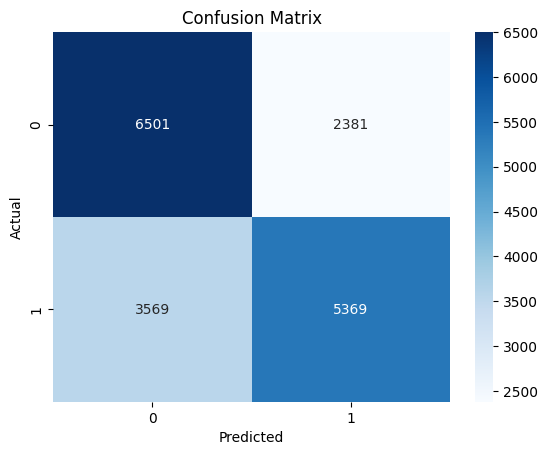

In [148]:
from sklearn.ensemble import GradientBoostingClassifier

# Train a Gradient Boosting Classifier
gb_model_c = GradientBoostingClassifier(random_state=42)
gb_model_c.fit(X_train_f_test_c, y_train_c)
y_pred_gb_c = gb_model_c.predict(X_test_f_test_c)

# Evaluate the model
accuracy_gb_c = accuracy_score(y_test_c, y_pred_gb_c)
conf_matrix_gb_c = confusion_matrix(y_test_c, y_pred_gb_c)
class_report_gb_c = classification_report(y_test_c, y_pred_gb_c)

print(f"Gradient Boosting - Accuracy: {accuracy_gb_c:.4f}")
print("Confusion Matrix:")
print(conf_matrix_gb_c)
print("Classification Report:")
print(class_report_gb_c)

# Visualize the confusion matrix
sns.heatmap(conf_matrix_gb_c, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:

################    dup
# parameter grid for gb
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the classifiers
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

# Initialize GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, n_jobs=-1, scoring='accuracy')
gb_grid_search = GridSearchCV(estimator=gb, param_grid=gb_param_grid, cv=5, n_jobs=-1, scoring='accuracy')

# Fit GridSearchCV
rf_grid_search.fit(X_train_selected, y_train)
gb_grid_search.fit(X_train_selected, y_train)

# Get the best models
best_rf_model = rf_grid_search.best_estimator_
best_gb_model = gb_grid_search.best_estimator_

# Make predictions
y_pred_rf = best_rf_model.predict(X_test_selected)
y_pred_gb = best_gb_model.predict(X_test_selected)

# Evaluate Random Forest
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)

print(f"Best Random Forest - Accuracy: {accuracy_rf:.4f}")
print("Confusion Matrix:")
print(conf_matrix_rf)
print("Classification Report:")
print(class_report_rf)

# Evaluate Gradient Boosting
accuracy_gb = accuracy_score(y_test, y_pred_gb)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
class_report_gb = classification_report(y_test, y_pred_gb)

print(f"Best Gradient Boosting - Accuracy: {accuracy_gb:.4f}")
print("Confusion Matrix:")
print(conf_matrix_gb)
print("Classification Report:")
print(class_report_gb)

# Feature importances from the best models
rf_feature_importance = pd.DataFrame({'feature': selected_features_f_test, 'importance': best_rf_model.feature_importances_})
gb_feature_importance = pd.DataFrame({'feature': selected_features_f_test, 'importance': best_gb_model.feature_importances_})

print("Random Forest Feature Importances:")
print(rf_feature_importance.sort_values(by='importance', ascending=False))

print("Gradient Boosting Feature Importances:")
print(gb_feature_importance.sort_values(by='importance', ascending=False))

# Visualize feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=rf_feature_importance.sort_values(by='importance', ascending=False))
plt.title('Random Forest Feature Importances')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=gb_feature_importance.sort_values(by='importance', ascending=False))
plt.title('Gradient Boosting Feature Importances')
plt.show()

# statistical testings 

# compare 2 groups t test
#### 1. Independence of Observations- should be covered within the study 
#### 2. normality: Perform Shapiro-Wilk test for normality
#### 3. Homogeneity of Variances - Perform Levene's test for equality of variances

In [150]:
#for hypothesis testings we are using more raw/original data 
#we only did imputation earlier after the train test split instead on original df, for the sake of stats testings, we will do the imputation again 

# fill missing values
df[num_col] = df[num_col].fillna(df[num_col].median())
df[cat_col] = df[cat_col].fillna(df[cat_col].mode().iloc[0])

# check if there are any remaining missing values
print(df.isnull().sum())

ClaimNumber                  0
DateTimeOfAccident           0
DateReported                 0
Age                          0
Gender                       0
MaritalStatus                0
DependentChildren            0
DependentsOther              0
WeeklyWages                  0
PartTimeFullTime             0
HoursWorkedPerWeek           0
DaysWorkedPerWeek            0
ClaimDescription             0
InitialIncurredCalimsCost    0
UltimateIncurredClaimCost    0
DateTimeOfAccident_month     0
DateTimeOfAccident_year      0
DateReported_month           0
DateReported_year            0
dtype: int64


In [157]:
df['PartTimeFullTime'].unique()

['F', 'P']
Categories (2, object): ['F', 'P']

#### T-statistic: This value indicates the ratio of the difference between the group means to the variability of the groups. A higher absolute value of the t-statistic indicates a greater difference between the groups.
#### P-value: This value indicates the probability that the observed difference between the groups happened by chance. A low p-value (typically less than 0.05) suggests that the difference between the groups is statistically significant.

In [163]:
###
group1 = df[df['PartTimeFullTime'] == 'F']['UltimateIncurredClaimCost']
group2 = df[df['PartTimeFullTime'] == 'P']['UltimateIncurredClaimCost']

Shapiro-Wilk Test for Group 1: Statistic=0.785686731338501, p-value=0.0
Shapiro-Wilk Test for Group 2: Statistic=0.8174612522125244, p-value=0.0


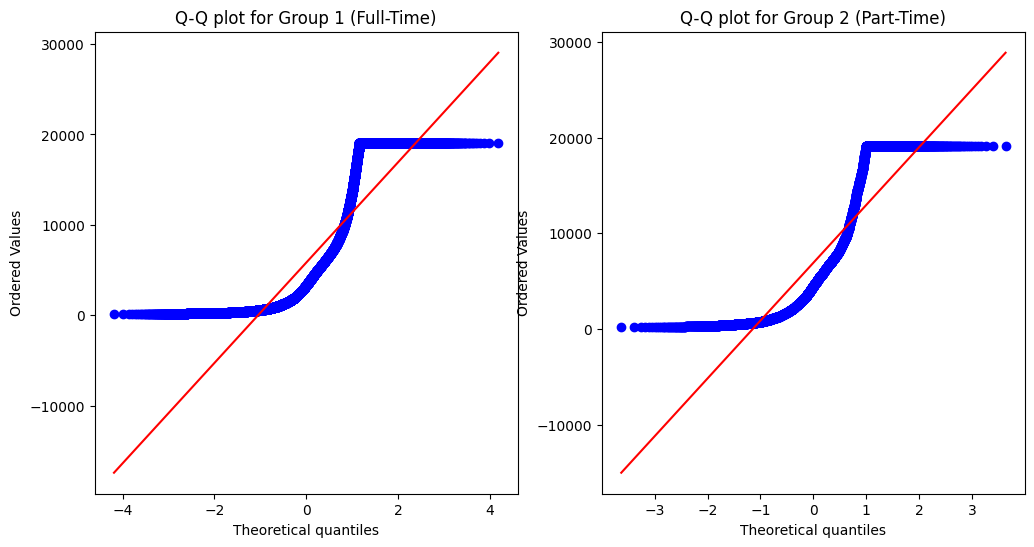

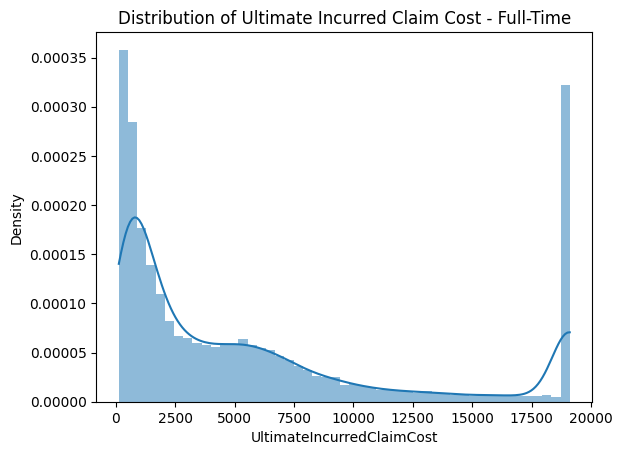

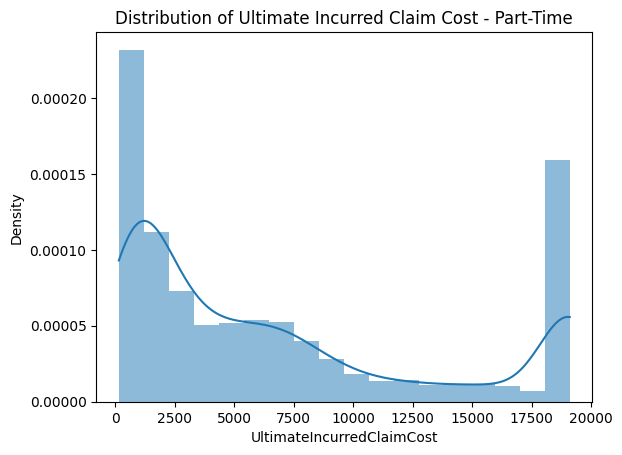

In [164]:
#lets check the assumptions for t test to see if there is any adj we need to make 
#1. Independence of Observations- should be covered within the study 
#2. normality: 
# Perform Shapiro-Wilk test for normality
shapiro_group1 = stats.shapiro(group1)
shapiro_group2 = stats.shapiro(group2)
print(f"Shapiro-Wilk Test for Group 1: Statistic={shapiro_group1.statistic}, p-value={shapiro_group1.pvalue}")
print(f"Shapiro-Wilk Test for Group 2: Statistic={shapiro_group2.statistic}, p-value={shapiro_group2.pvalue}")

# Q-Q plots
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
stats.probplot(group1, dist="norm", plot=ax[0])
ax[0].set_title('Q-Q plot for Group 1 (Full-Time)')
stats.probplot(group2, dist="norm", plot=ax[1])
ax[1].set_title('Q-Q plot for Group 2 (Part-Time)')
plt.show()

# Histograms
sns.histplot(group1, kde=True, stat="density", linewidth=0)
plt.title('Distribution of Ultimate Incurred Claim Cost - Full-Time')
plt.show()

sns.histplot(group2, kde=True, stat="density", linewidth=0)
plt.title('Distribution of Ultimate Incurred Claim Cost - Part-Time')
plt.show()

### not normally distributed 

In [165]:
# 3. Homogeneity of Variances

# Perform Levene's test for equality of variances
levene_test = stats.levene(group1, group2)
print(f"Levene's Test: Statistic={levene_test.statistic}, p-value={levene_test.pvalue}")


Levene's Test: Statistic=81.59467448684134, p-value=1.7241748392534375e-19


### Homogeneity of Variances also not satisfied,  
### use Mann-Whitney U Test - The Mann-Whitney U test is a non-parametric test that compares the medians of two independent groups. It does not require the assumptions of normality or equal variances, making it suitable for your data.



Mann-Whitney U Test: Statistic=106730037.5, p-value=1.464703636034241e-37


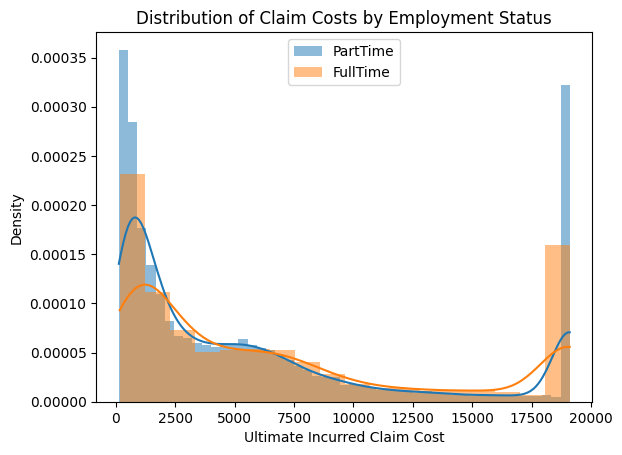

In [166]:
# Perform Mann-Whitney U test
mannwhitney = stats.mannwhitneyu(group1, group2)
print(f"Mann-Whitney U Test: Statistic={mannwhitney.statistic}, p-value={mannwhitney.pvalue}")

# Visualize the distributions for both groups
sns.histplot(group1, kde=True, stat="density", linewidth=0, label='PartTime')
sns.histplot(group2, kde=True, stat="density", linewidth=0, label='FullTime')
plt.title('Distribution of Claim Costs by Employment Status')
plt.xlabel('Ultimate Incurred Claim Cost')
plt.ylabel('Density')
plt.legend()
plt.show()


### U Statistic: Indicates the rank sum of the data points from one group compared to the other group.
### P-value: If the p-value is less than 0.05, it suggests that there is a statistically significant difference between the two groups.
## A significant p-value indicates a significant difference in claim costs between part-time and full-time employees.

# if assumptions met here is the normal t test 

T-test: t-statistic = -11.8196, p-value = 0.0000


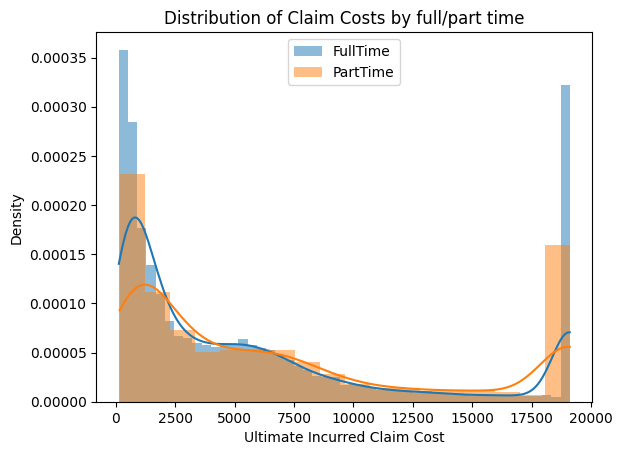

In [158]:
#T-Test: compare means of two groups

t_stat, p_val = stats.ttest_ind(group1, group2)
print(f"T-test: t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

#  check normality for T-test groups
sns.histplot(group1, kde=True, stat="density", linewidth=0, label='FullTime')
sns.histplot(group2, kde=True, stat="density", linewidth=0, label='PartTime')
plt.title('Distribution of Claim Costs by full/part time')
plt.xlabel('Ultimate Incurred Claim Cost')
plt.ylabel('Density')
plt.legend()
plt.show()

##### Observation: The density plots show the distribution of UltimateIncurredClaimCost for both full-time and part-time employees. There is noticeable overlap, but also some differences in the distributions, especially at the high-cost end.
##### Implication: While the distributions overlap, the significant difference in the means is notable and worth further investigation.

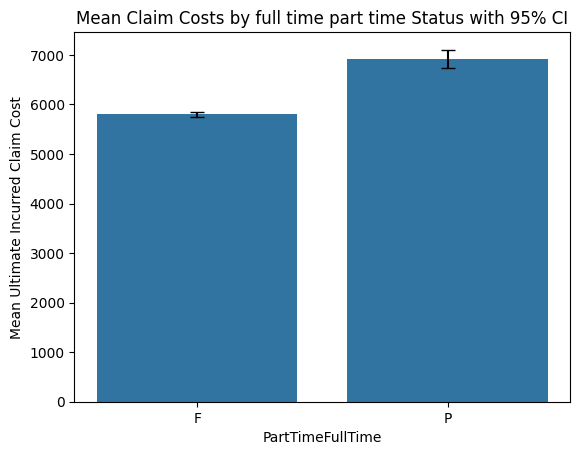

In [159]:
# Calculate means and confidence intervals
means = df.groupby('PartTimeFullTime')['UltimateIncurredClaimCost'].mean()
cis = df.groupby('PartTimeFullTime')['UltimateIncurredClaimCost'].agg(lambda x: stats.t.interval(0.95, len(x)-1, loc=np.mean(x), scale=stats.sem(x)))

# Create a bar plot with error bars
fig, ax = plt.subplots()
sns.barplot(x=means.index, y=means.values, ax=ax, capsize=0.1)
ax.errorbar(x=means.index, y=means.values, yerr=[(top-bot)/2 for bot, top in cis], fmt='none', c='black', capsize=5)
ax.set_title('Mean Claim Costs by full time part time Status with 95% CI')
ax.set_ylabel('Mean Ultimate Incurred Claim Cost')
plt.show()

##### Observation: The bar plot shows that the mean claim cost for part-time employees is higher than for full-time employees, and the error bars (representing 95% confidence intervals) do not overlap.
##### Implication: The non-overlapping confidence intervals reinforce the result of the T-test, suggesting a significant difference in mean claim costs between the two groups.

In [160]:
df.columns

Index(['ClaimNumber', 'DateTimeOfAccident', 'DateReported', 'Age', 'Gender',
       'MaritalStatus', 'DependentChildren', 'DependentsOther', 'WeeklyWages',
       'PartTimeFullTime', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek',
       'ClaimDescription', 'InitialIncurredCalimsCost',
       'UltimateIncurredClaimCost', 'DateTimeOfAccident_month',
       'DateTimeOfAccident_year', 'DateReported_month', 'DateReported_year'],
      dtype='object')

# compare multiple groups - ANOVA : 
#### ANOVA: Perform ANOVA to compare the means across the three categories.
#### Visualization: Plot the distribution of claim costs for all three categories to visualize the differences.
#### Post-hoc Testing: If ANOVA is significant, use post-hoc tests like Tukey's HSD to determine which specific groups are different.

#### 1. Independence of Observations- should be covered within the study 
#### 2. normality: Perform Shapiro-Wilk test for normality
#### 3. Homogeneity of Variances - Perform Levene's test for equality of variances

Shapiro-Wilk Test for M: Statistic=0.8102947473526001, p-value=0.0


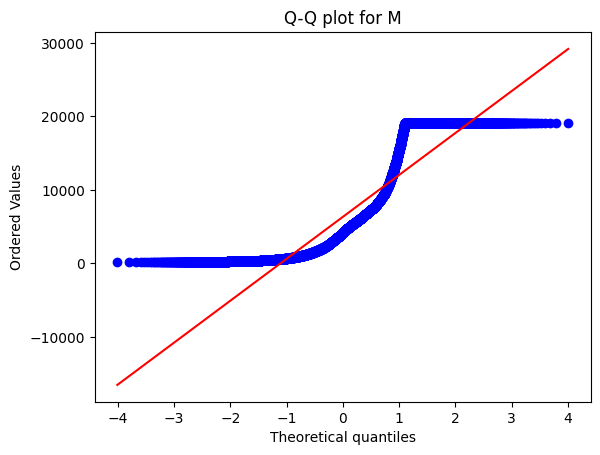

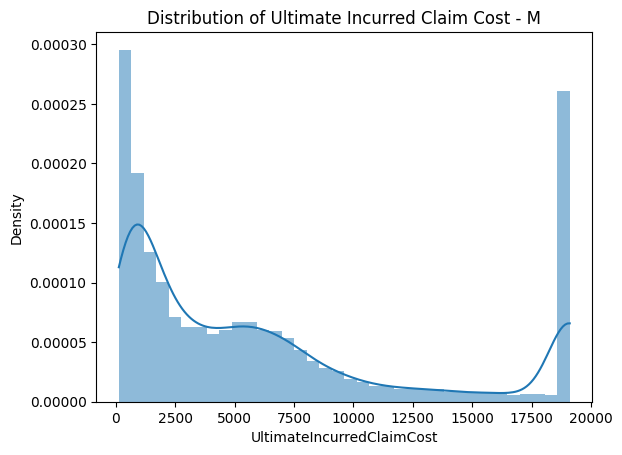

Shapiro-Wilk Test for U: Statistic=0.8402622938156128, p-value=0.0


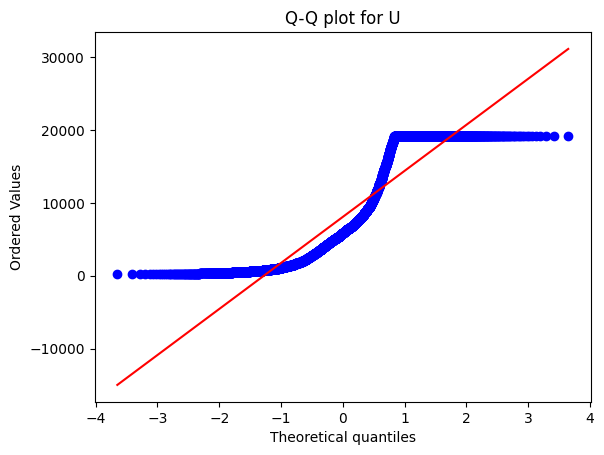

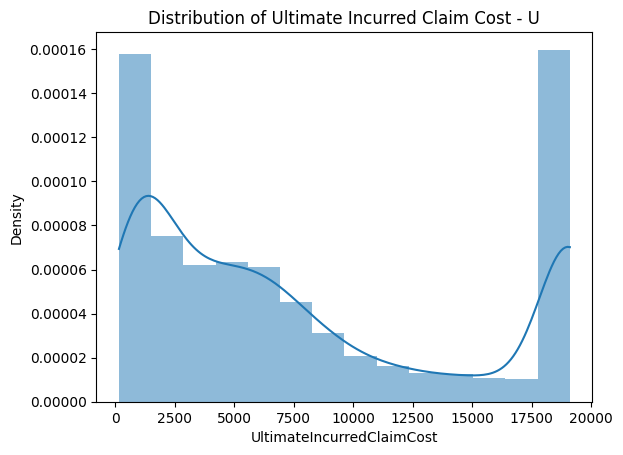

Shapiro-Wilk Test for S: Statistic=0.7518582344055176, p-value=0.0


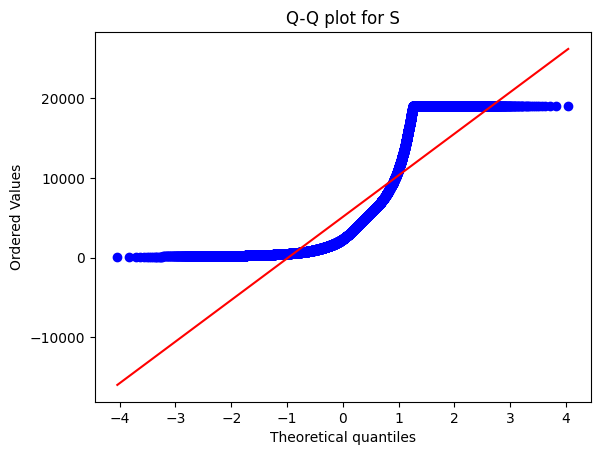

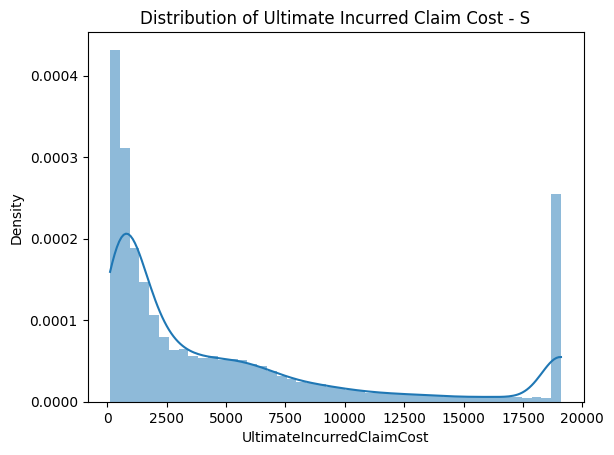

In [174]:
# Check normality for each group
groups = df['MaritalStatus'].unique()
for group in groups:
    group_data = df[df['MaritalStatus'] == group]['UltimateIncurredClaimCost']
    shapiro_test = stats.shapiro(group_data)
    print(f'Shapiro-Wilk Test for {group}: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}')
    
    # Q-Q plot
    stats.probplot(group_data, dist="norm", plot=plt)
    plt.title(f'Q-Q plot for {group}')
    plt.show()

    # Histogram
    sns.histplot(group_data, kde=True, stat="density", linewidth=0)
    plt.title(f'Distribution of Ultimate Incurred Claim Cost - {group}')
    plt.show()

### not normal - using data transformations (log, square root) or a non-parametric equivalent like the Kruskal-Wallis test.

In [175]:
# Levene's test for homogeneity of variances
levene_test = stats.levene(df[df['MaritalStatus'] == 'M']['UltimateIncurredClaimCost'],
                           df[df['MaritalStatus'] == 'S']['UltimateIncurredClaimCost'],
                           df[df['MaritalStatus'] == 'U']['UltimateIncurredClaimCost'])
print(f"Levene's Test: Statistic={levene_test.statistic}, p-value={levene_test.pvalue}")

Levene's Test: Statistic=236.22699714288703, p-value=7.147255322918976e-103


### homogeneity not satisfied - consider using Welch’s ANOVA or transforming the data.
## since both not mat we will use kruskal 

In [177]:
# Perform Kruskal-Wallis test
kruskal_test = stats.kruskal(df[df['MaritalStatus'] == 'M']['UltimateIncurredClaimCost'],
                             df[df['MaritalStatus'] == 'S']['UltimateIncurredClaimCost'],
                             df[df['MaritalStatus'] == 'U']['UltimateIncurredClaimCost'])
print(f"Kruskal-Wallis Test: Statistic={kruskal_test.statistic}, p-value={kruskal_test.pvalue}")

## Statistic: Indicates the sum of ranks difference.
## P-value: If the p-value is less than 0.05, it suggests that there is a significant difference between the groups.

Kruskal-Wallis Test: Statistic=1496.9981464657458, p-value=0.0


## there are sig diff among groups, but since not normal no equal variance, we will use dunn 

In [181]:
pip install scikit-posthocs


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [182]:
import scikit_posthocs as sp

# Prepare data for Dunn's test
data = df[['UltimateIncurredClaimCost', 'MaritalStatus']]

# Perform Dunn's test
dunn_test = sp.posthoc_dunn(data, val_col='UltimateIncurredClaimCost', group_col='MaritalStatus', p_adjust='bonferroni')
print(dunn_test)

               M              S              U
M   1.000000e+00  1.395120e-156   7.369724e-72
S  1.395120e-156   1.000000e+00  6.977176e-258
U   7.369724e-72  6.977176e-258   1.000000e+00


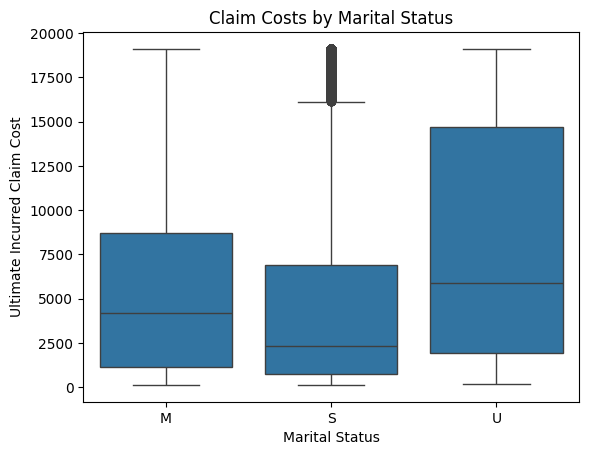

In [183]:
# Boxplot to visualize the differences
sns.boxplot(x='MaritalStatus', y='UltimateIncurredClaimCost', data=df)
plt.title('Claim Costs by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Ultimate Incurred Claim Cost')
plt.show()

#### Summary of Interpretation
######  Married (M) vs Single (S): There is a highly significant difference in the UltimateIncurredClaimCost between married and single individuals.
######  Married (M) vs Unknown (U): There is a highly significant difference in the UltimateIncurredClaimCost between married and unknown marital status individuals.
######  Single (S) vs Unknown (U): There is a highly significant difference in the UltimateIncurredClaimCost between single and unknown marital status individuals.
##### Practical Implications
###### These results suggest that the UltimateIncurredClaimCost varies significantly across different marital status groups. You can use these findings to draw insights and potentially guide decision-making in the context of workers' compensation claims:

###### Policy Adjustments: Adjust policies based on marital status to better manage claim costs.
###### Targeted Interventions: Develop targeted interventions for different marital status groups to reduce claim costs.
###### Further Investigation: Explore underlying reasons for these differences to develop more tailored strategies.

# if assumptions met here is the normal anova and post hoc 

In [171]:

# Perform ANOVA
model = ols('UltimateIncurredClaimCost ~ C(MaritalStatus)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# If ANOVA is significant, proceed with post-hoc testing
if anova_table["PR(>F)"][0] < 0.05:
    print("ANOVA is significant, perform post-hoc tests")
else:
    print("ANOVA is not significant, no further tests needed")

                        sum_sq       df           F         PR(>F)
C(MaritalStatus)  4.465477e+10      2.0  573.108935  5.091973e-247
Residual          2.103635e+12  53997.0         NaN            NaN
ANOVA is significant, perform post-hoc tests


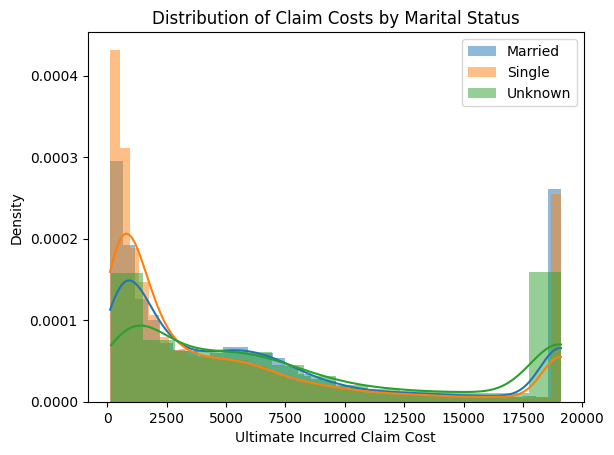

In [172]:
# Visualize the distributions for all categories
sns.histplot(df[df['MaritalStatus'] == 'M']['UltimateIncurredClaimCost'], kde=True, stat="density", linewidth=0, label='Married')
sns.histplot(df[df['MaritalStatus'] == 'S']['UltimateIncurredClaimCost'], kde=True, stat="density", linewidth=0, label='Single')
sns.histplot(df[df['MaritalStatus'] == 'U']['UltimateIncurredClaimCost'], kde=True, stat="density", linewidth=0, label='Unknown')
plt.title('Distribution of Claim Costs by Marital Status')
plt.xlabel('Ultimate Incurred Claim Cost')
plt.ylabel('Density')
plt.legend()
plt.show()

In [184]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=df['UltimateIncurredClaimCost'], groups=df['MaritalStatus'], alpha=0.05)
print(tukey)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
group1 group2  meandiff  p-adj   lower      upper   reject
----------------------------------------------------------
     M      S -1194.3762   0.0 -1327.3275 -1061.425   True
     M      U  1752.4994   0.0   1529.051 1975.9479   True
     S      U  2946.8757   0.0  2726.4309 3167.3204   True
----------------------------------------------------------


# Chi-Squared Test: Test for independence between categorical variables
#### Chi-Square Statistic (χ²): This value measures the difference between the observed and expected frequencies of the categories. Larger values indicate greater differences.
#### P-value: This value helps to determine the statistical significance of the test. A p-value less than 0.05 typically indicates that there is a significant association between the variables.
#### Degrees of Freedom (df): This is based on the number of categories in each variable and affects the interpretation of the Chi-Square statistic.

### assumption: 
#### Independence of Observations: Each observation can only be counted in one cell of the contingency table.
#### Expected Frequency: Each expected frequency count should be 5 or mor

Chi-Square Statistic: 3345.6276803150827
P-value: 0.0
Degrees of Freedom: 2
Expected Frequencies:
[[1.12211825e+04 1.11681748e+03]
 [3.78889985e+04 3.77100148e+03]
 [1.81896296e+00 1.81037037e-01]]


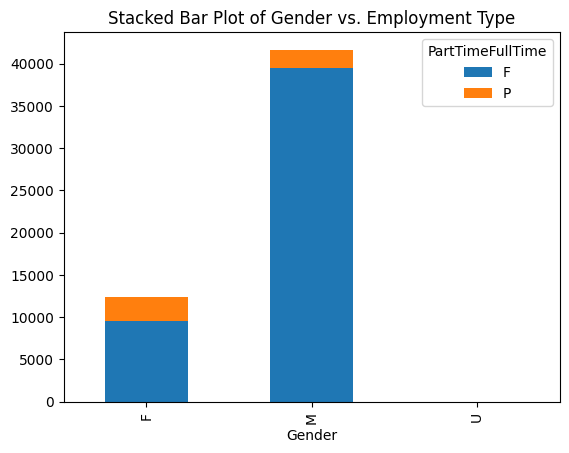

In [187]:
contingency_table = pd.crosstab(df['Gender'], df['PartTimeFullTime'])
chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(ex)

# Visualize the contingency table
contingency_table.plot(kind='bar', stacked=True)
plt.title('Stacked Bar Plot of Gender vs. Employment Type')
plt.show()

In [190]:

# Create contingency table
contingency_table2= pd.crosstab(df2['Gender'], df2['highcost'])

# Perform Chi-Square Test
chi2, p, dof, ex = stats.chi2_contingency(contingency_table2)
print(f"Chi-Square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(ex)

# Check if any expected frequency is less than 5
if (ex < 5).any():
    print("Some expected frequencies are less than 5.")
else:
    print("All expected frequencies are 5 or more.")

# Interpretation
if p < 0.05:
    print("There is a significant association between the feature and the target, confirming the importance of the feature.")
else:
    print("There is no significant association between the feature and the target.")


Chi-Square Statistic: 299.335708228473
P-value: 1.0001769460295702e-65
Degrees of Freedom: 2
Expected Frequencies:
[[6.169e+03 6.169e+03]
 [2.083e+04 2.083e+04]
 [1.000e+00 1.000e+00]]
Some expected frequencies are less than 5.
There is a significant association between the feature and the target, confirming the importance of the feature.


### Since some expected frequencies are less than 5, you need to address this issue. Here are two common solutions:
#### Combine Categories: Combine categories that have low expected frequencies to increase the expected counts.
#### Use Fisher's Exact Test: This test is more accurate for small sample sizes or when expected frequencies are low.

In [191]:
print(contingency_table2)


highcost      0      1
Gender                
F          5325   7013
M         21674  19986
U             1      1


In [192]:
# Example of combining categories if possible
# Assume 'Gender' has categories 'M', 'F', and 'U' (U being rare)

df2['Gender'] = df2['Gender'].replace({'U': 'M'})  # Combining 'U' into 'M'

# Recreate contingency table
contingency_table2 = pd.crosstab(df2['Gender'], df2['highcost'])

# Perform Chi-Square Test again
chi2, p, dof, ex = stats.chi2_contingency(contingency_table2)
print(f"Updated Chi-Square Statistic: {chi2}")
print(f"Updated P-value: {p}")
print(f"Updated Degrees of Freedom: {dof}")
print("Updated Expected Frequencies:")
print(ex)

# Check if any expected frequency is less than 5
if (ex < 5).any():
    print("Some expected frequencies are less than 5. Consider using Fisher's Exact Test.")
else:
    print("All expected frequencies are 5 or more.")

# Interpretation
if p < 0.05:
    print("There is a significant association between the feature and the target, confirming the importance of the feature.")
else:
    print("There is no significant association between the feature and the target.")

Updated Chi-Square Statistic: 298.9778706730797
Updated P-value: 5.5012346549198884e-67
Updated Degrees of Freedom: 1
Updated Expected Frequencies:
[[ 6169.  6169.]
 [20831. 20831.]]
All expected frequencies are 5 or more.
There is a significant association between the feature and the target, confirming the importance of the feature.


In [194]:
# previous did work, but if it didn't , we will try this 
# Perform Fisher's Exact Test
fisher_test = stats.fisher_exact(contingency_table2)
print(f"Fisher's Exact Test: p-value = {fisher_test[1]}")

# Interpretation
if fisher_test[1] < 0.05:
    print("There is a significant association between the feature and the target, confirming the importance of the feature.")
else:
    print("There is no significant association between the feature and the target.")


Fisher's Exact Test: p-value = 3.794520013493729e-67
There is a significant association between the feature and the target, confirming the importance of the feature.


In [204]:
df

ClaimNumber        DateTimeOfAccident              DateReported   Age  \
0       WC8285054 2002-04-09 03:00:00-04:00 2002-07-04 20:00:00-04:00  48.0   
1       WC6982224 1999-01-07 06:00:00-05:00 1999-01-19 19:00:00-05:00  43.0   
2       WC5481426 1996-03-24 19:00:00-05:00 1996-04-13 20:00:00-04:00  30.0   
3       WC9775968 2005-06-22 09:00:00-04:00 2005-07-21 20:00:00-04:00  41.0   
4       WC2634037 1990-08-29 04:00:00-04:00 1990-09-26 20:00:00-04:00  36.0   
...           ...                       ...                       ...   ...   
53995   WC9370727 2004-08-21 14:00:00-04:00 2004-09-07 20:00:00-04:00  32.0   
53996   WC8396269 2002-04-28 05:00:00-04:00 2002-09-02 20:00:00-04:00  20.0   
53997   WC3609528 1992-02-28 04:00:00-05:00 1992-03-17 19:00:00-05:00  19.0   
53998   WC5038565 1995-01-10 02:00:00-05:00 1995-01-30 19:00:00-05:00  24.0   
53999   WC2542601 1990-10-24 10:00:00-04:00 1990-11-02 19:00:00-05:00  22.0   

      Gender MaritalStatus  DependentChildren  DependentsOther  WeeklyWages  \
0          M             M                0.0              0.0   500.000000   
1          F             M                0.0              0.0   509.339996   
2          M             U                0.0              0.0   709.099976   
3          M             S                0.0              0.0   555.460022   
4          M             M                0.0              0.0   377.100006   
...      ...           ...                ...              ...          ...   
53995      F             S                0.0              0.0   500.000000   
53996      F             S                0.0              0.0   500.000000   
53997      M             S                0.0              0.0   283.000000   
53998      M             S                0.0              0.0   200.000000   
53999      M             S                0.0              0.0   200.000000   

      PartTimeFullTime  HoursWorkedPerWeek  DaysWorkedPerWeek  \
0                    F                38.0                5.0   
1                    F                37.5                5.0   
2                    F                38.0                5.0   
3                    F                38.0                5.0   
4                    F                38.0                5.0   
...                ...                 ...                ...   
53995                F                38.0                5.0   
53996                F                40.0                5.0   
53997                F                40.0                5.0   
53998                F                38.0                5.0   
53999                F                38.0                5.0   

                                        ClaimDescription  \
0      LIFTING TYRE INJURY TO RIGHT ARM AND WRIST INJURY   
1      STEPPED AROUND CRATES AND TRUCK TRAY FRACTURE ...   
2                       CUT ON SHARP EDGE CUT LEFT THUMB   
3                   DIGGING LOWER BACK LOWER BACK STRAIN   
4      REACHING ABOVE SHOULDER LEVEL ACUTE MUSCLE STR...   
...                                                  ...   
53995  STRUCK KNIFE LACERATED LEFT MIDDLE FINGER LEFT...   
53996   LEFT HAND LACERATION LEFT SIDE BACK AND LEFT LEG   
53997              METAL SLIPPED ACROSS METAL CUT FINGER   
53998  BURN WHILST USING SPANNER LACERATION RIGHT MID...   
53999  CUT WITH BREAD KNIFE LACERATION LEFT INDEX AND...   

       InitialIncurredCalimsCost  UltimateIncurredClaimCost  \
0                         1500.0                4748.203613   
1                         5500.0                6326.285645   
2                         1700.0                2293.948975   
3                        15000.0               17786.486328   
4                         2800.0                4014.002930   
...                          ...                        ...   
53995                     1000.0                 480.493317   
53996                     1000.0                 755.735291   
53997                      210.0       

# time series

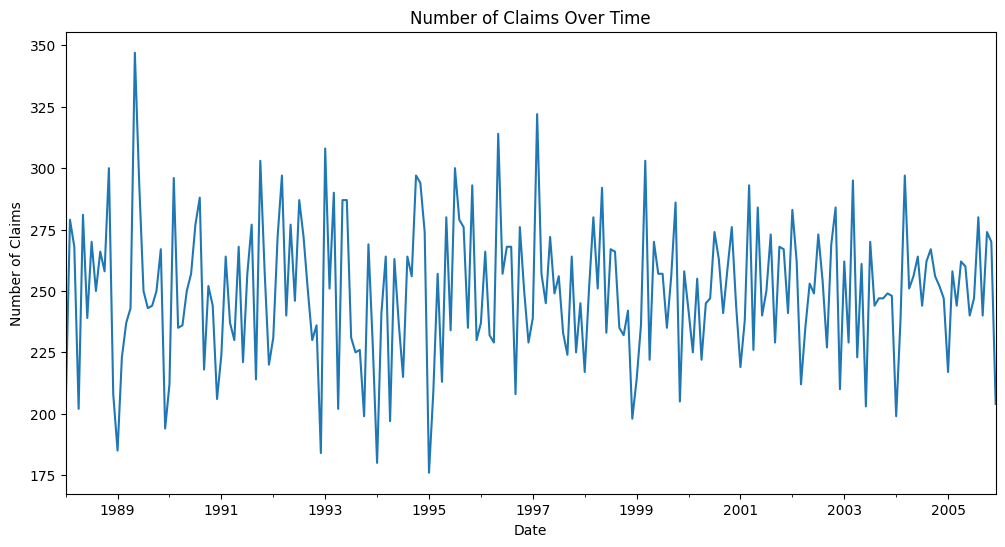

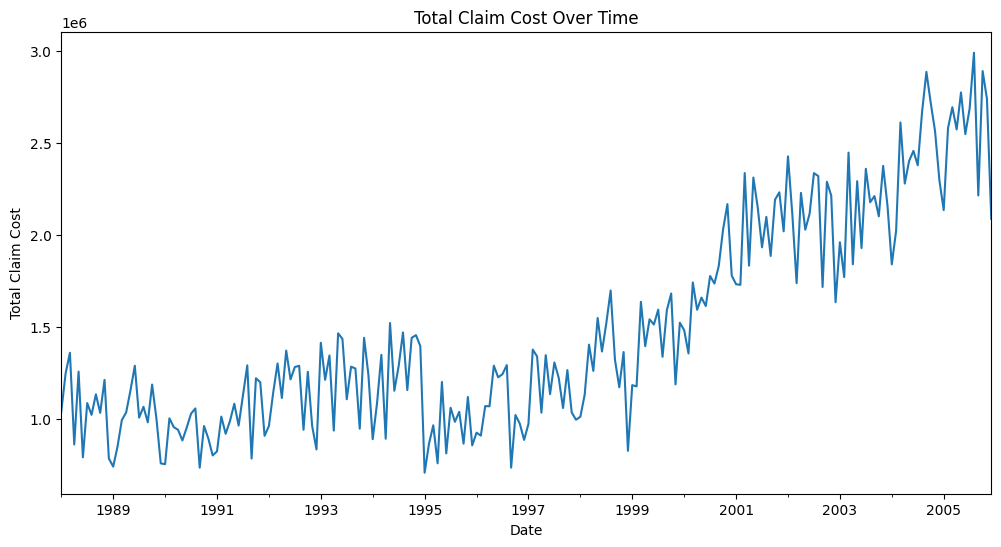

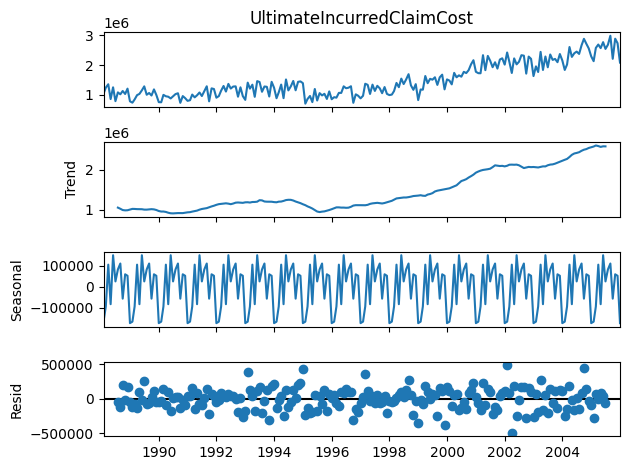

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Create a copy of the DataFrame
df3 = df.copy()

# Ensure 'DateTimeOfAccident' is in datetime format
df3['DateTimeOfAccident'] = pd.to_datetime(df3['DateTimeOfAccident'])

# Set 'DateTimeOfAccident' as the index
df3.set_index('DateTimeOfAccident', inplace=True)

# Aggregate data by month
monthly_claims = df3.resample('M').size()
monthly_claims_cost = df3.resample('M')['UltimateIncurredClaimCost'].sum()

# Plot number of claims over time
plt.figure(figsize=(12, 6))
monthly_claims.plot()
plt.title('Number of Claims Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Claims')
plt.show()

# Plot total claim cost over time
plt.figure(figsize=(12, 6))
monthly_claims_cost.plot()
plt.title('Total Claim Cost Over Time')
plt.xlabel('Date')
plt.ylabel('Total Claim Cost')
plt.show()

# Decompose the time series to observe trend, seasonality, and residuals
# Adjust period parameter to match available data length
period = 12  # Typically 12 for monthly data to observe yearly seasonality

decomposition = seasonal_decompose(monthly_claims_cost, model='additive', period=period)
decomposition.plot()
plt.show()

In [25]:
monthly_claims_cost

DateTimeOfAccident
1988-01-31 00:00:00-05:00    1038468.625
1988-02-29 00:00:00-05:00    1245600.750
1988-03-31 00:00:00-05:00    1358025.625
1988-04-30 00:00:00-04:00     859514.000
1988-05-31 00:00:00-04:00    1255656.500
                                ...     
2005-08-31 00:00:00-04:00    2988873.250
2005-09-30 00:00:00-04:00    2212910.000
2005-10-31 00:00:00-05:00    2889174.250
2005-11-30 00:00:00-05:00    2737919.250
2005-12-31 00:00:00-05:00    2085845.250
Freq: M, Name: UltimateIncurredClaimCost, Length: 216, dtype: float32

### Observation: This represents the actual values of the UltimateIncurredClaimCost over time. The overall trend appears to be increasing.
### Action: It’s useful for getting a general sense of the data over time.

## Trend:

### Observation: There is a clear upward trend from 1990 to 2005, indicating that the total claim cost has been increasing over this period.
### Action: Understanding the trend can help in forecasting future values and planning long-term strategies.
## Seasonal:

### Observation: The seasonal component shows regular, repeating patterns over the years. The peaks and troughs in the seasonal component indicate that there are specific times of the year when claim costs are consistently higher or lower.
### Action: This information can be used for seasonal planning, budgeting, and resource allocation.
## Residual:

### Observation: The residual component represents the noise in the data. Ideally, residuals should be randomly scattered without any pattern.
### Action: If patterns are observed in the residuals, it may indicate that the model could be improved by including additional variables or using a different model.

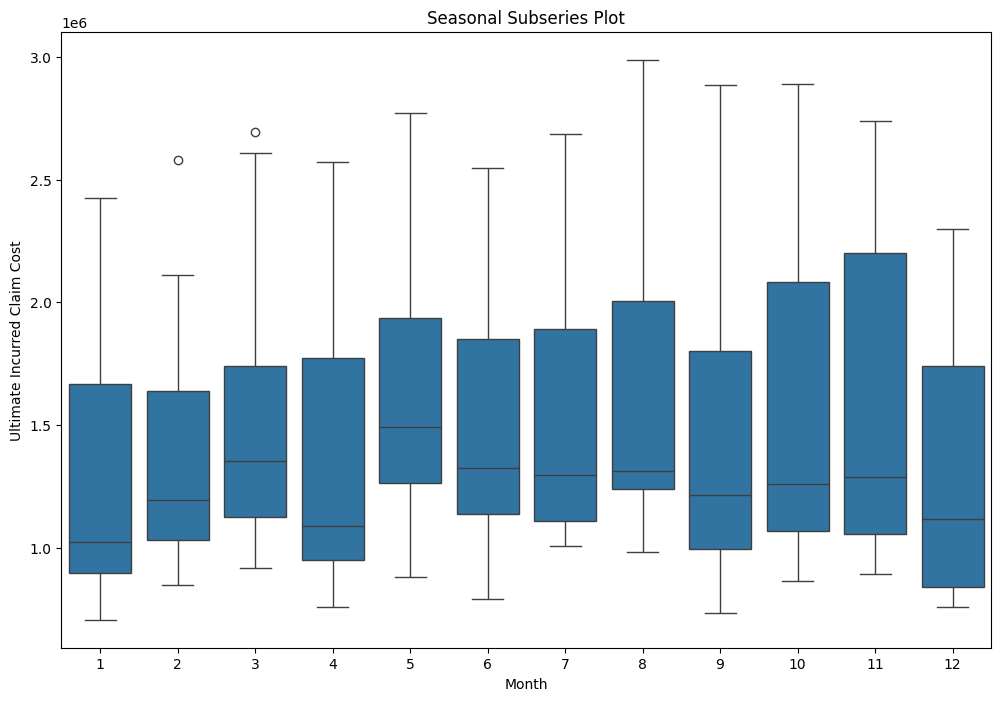

In [26]:
# Create a DataFrame for seasonal subseries plot
monthly_claims_cost = monthly_claims_cost.reset_index()
monthly_claims_cost['Year'] = monthly_claims_cost['DateTimeOfAccident'].dt.year
monthly_claims_cost['Month'] = monthly_claims_cost['DateTimeOfAccident'].dt.month

plt.figure(figsize=(12, 8))
sns.boxplot(x='Month', y='UltimateIncurredClaimCost', data=monthly_claims_cost)
plt.title('Seasonal Subseries Plot')
plt.xlabel('Month')
plt.ylabel('Ultimate Incurred Claim Cost')
plt.show()

In [27]:
monthly_claims_cost

DateTimeOfAccident  UltimateIncurredClaimCost  Year  Month
0   1988-01-31 00:00:00-05:00                1038468.625  1988      1
1   1988-02-29 00:00:00-05:00                1245600.750  1988      2
2   1988-03-31 00:00:00-05:00                1358025.625  1988      3
3   1988-04-30 00:00:00-04:00                 859514.000  1988      4
4   1988-05-31 00:00:00-04:00                1255656.500  1988      5
..                        ...                        ...   ...    ...
211 2005-08-31 00:00:00-04:00                2988873.250  2005      8
212 2005-09-30 00:00:00-04:00                2212910.000  2005      9
213 2005-10-31 00:00:00-05:00                2889174.250  2005     10
214 2005-11-30 00:00:00-05:00                2737919.250  2005     11
215 2005-12-31 00:00:00-05:00                2085845.250  2005     12

[216 rows x 4 columns]

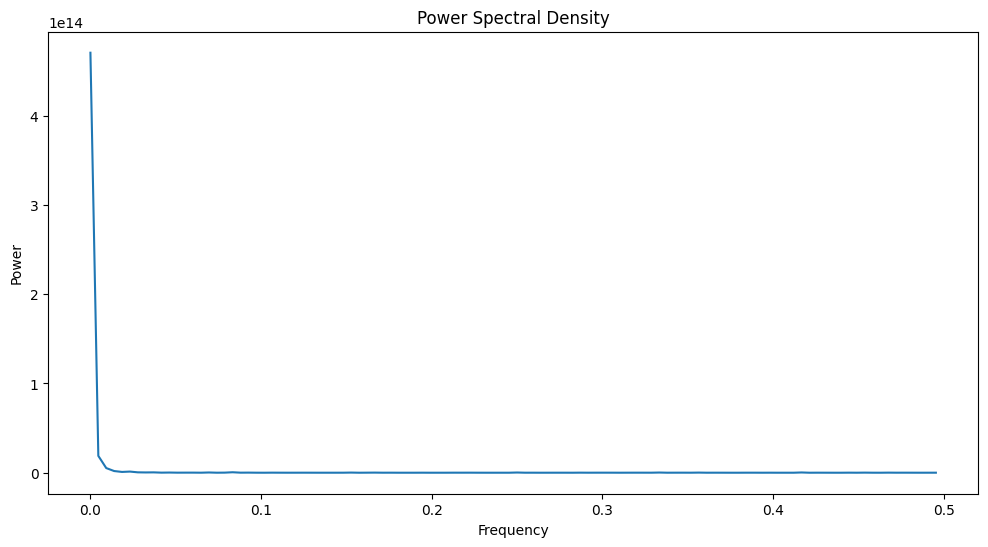

In [12]:
import numpy as np
from scipy.fft import fft

# Ensure 'monthly_claims_cost' is a numpy array
monthly_claims_cost_values = monthly_claims_cost['UltimateIncurredClaimCost'].values

# Perform Fourier transformation
n = len(monthly_claims_cost_values)
fhat = fft(monthly_claims_cost_values)
PSD = np.abs(fhat)**2 / n
freq = np.fft.fftfreq(n, 1)  # Assume unit time spacing

# Plot the power spectral density
plt.figure(figsize=(12, 6))
plt.plot(freq[:n//2], PSD[:n//2])
plt.title('Power Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

### Summary
#### Lag in ACF: Indicates how current values are correlated with past values at different time steps (lags). Helps identify trends and seasonality.
#### Frequency in PSD: Indicates the presence of cycles at different frequencies. Helps identify dominant periodic components in the time series.

## ARIMA

<Figure size 1200x600 with 0 Axes>

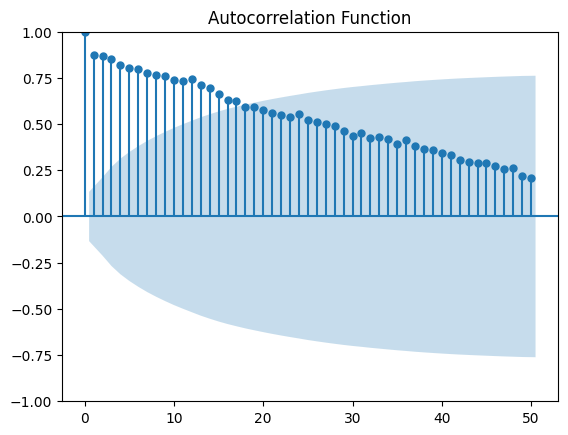

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
#Plots the ACF to identify the lagged correlations of the time series.
plt.figure(figsize=(12, 6))
plot_acf(monthly_claims_cost['UltimateIncurredClaimCost'], lags=50)
plt.title('Autocorrelation Function')
plt.show()

<Figure size 1200x600 with 0 Axes>

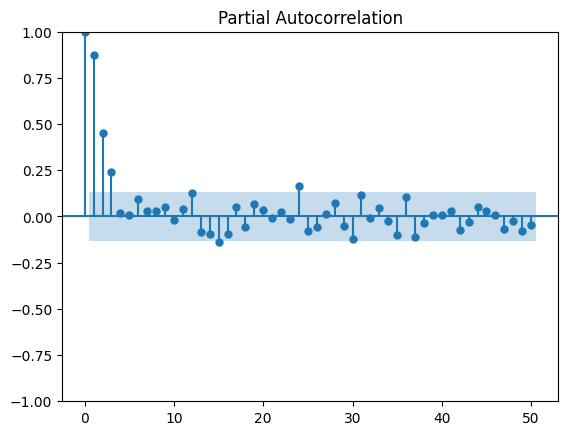

In [17]:
#Plots the PACF to identify the direct effects of previous terms in the time series.
plt.figure(figsize=(12, 6))
plot_pacf(monthly_claims_cost['UltimateIncurredClaimCost'], lags=50)
plt.show()

In [22]:
result = adfuller(monthly_claims_cost['UltimateIncurredClaimCost'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print('Critical Value (%s): %.3f' % (key, value))

ADF Statistic: 1.3570607451536183
p-value: 0.996910071925852
Critical Value (1%): -3.463
Critical Value (5%): -2.876
Critical Value (10%): -2.574


In [30]:
#Sets the differencing order d. If the series is stationary, d is 0; otherwise, d is 1.
if result[1] < 0.05:
    d = 0
else:
    d = 1


# Set p and q based on ACF and PACF plots
p = 1  # Based on PACF plot
q = 5  # Based on ACF plot

# Fit ARIMA model
model = ARIMA(monthly_claims_cost['UltimateIncurredClaimCost'], order=(p, d, q))
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=12)
print(forecast)

                                   SARIMAX Results                                   
Dep. Variable:     UltimateIncurredClaimCost   No. Observations:                  216
Model:                        ARIMA(1, 1, 5)   Log Likelihood               -2951.345
Date:                       Wed, 29 May 2024   AIC                           5916.689
Time:                               10:02:16   BIC                           5940.284
Sample:                                    0   HQIC                          5926.223
                                       - 216                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7395      0.134      5.530      0.000       0.477       1.002
ma.L1         -1.5562      0.138    -11.247      0.000      -1.827      -1.

## SARIMA 

<Figure size 1200x600 with 0 Axes>

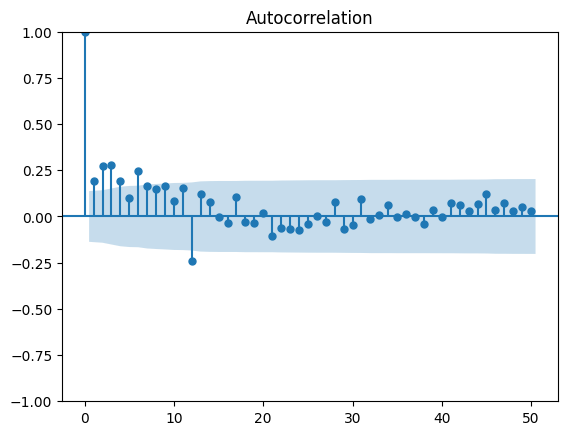

<Figure size 1200x600 with 0 Axes>

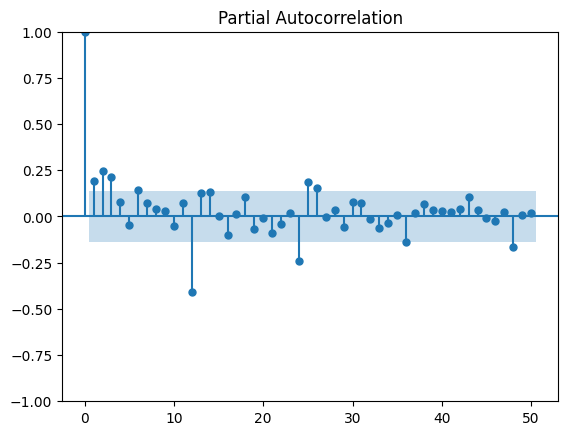

In [33]:
# Seasonal differencing 
s = 12 
monthly_claims_cost_seasonal_diff = monthly_claims_cost['UltimateIncurredClaimCost'].diff(s).dropna()

# Plot seasonal ACF
plt.figure(figsize=(12, 6))
plot_acf(monthly_claims_cost_seasonal_diff, lags=50)
plt.show()

# Plot seasonal PACF
plt.figure(figsize=(12, 6))
plot_pacf(monthly_claims_cost_seasonal_diff, lags=50)
plt.show()

In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Set seasonal period
s = 12  # Monthly data with yearly seasonality

# Fit SARIMA model
model = SARIMAX(monthly_claims_cost['UltimateIncurredClaimCost'], order=(1, 1, 5), seasonal_order=(1, 1, 1, s))
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast = model_fit.forecast(steps=12)
print(forecast)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31397D+01    |proj g|=  5.79593D-01

At iterate    5    f=  1.28978D+01    |proj g|=  4.30967D-02

At iterate   10    f=  1.28863D+01    |proj g|=  2.23742D-03

At iterate   15    f=  1.28859D+01    |proj g|=  9.64442D-03

At iterate   20    f=  1.28834D+01    |proj g|=  5.46988D-03

At iterate   25    f=  1.28816D+01    |proj g|=  1.34251D-02

At iterate   30    f=  1.28811D+01    |proj g|=  6.41560D-04

At iterate   35    f=  1.28811D+01    |proj g|=  1.21183D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

# survival analysis 

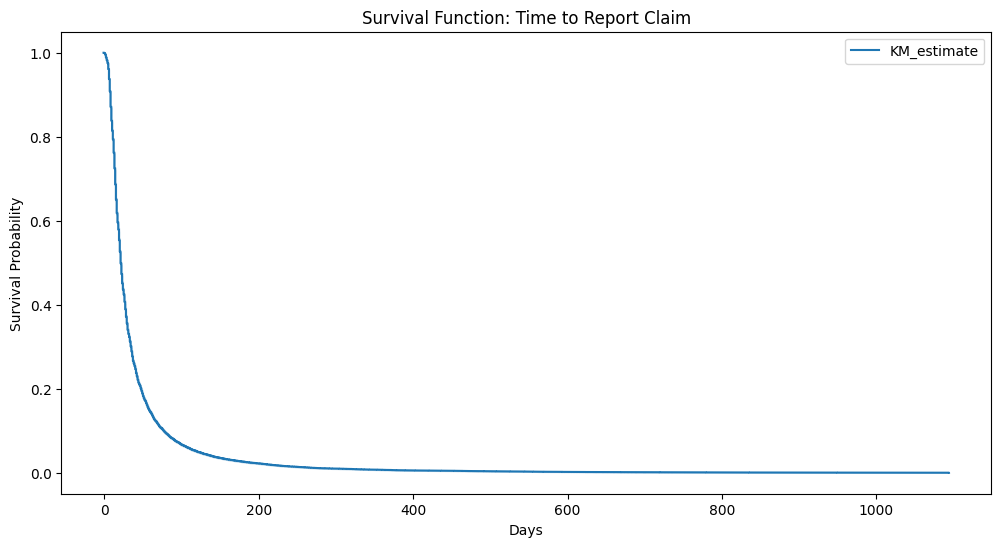

<lifelines.CoxPHFitter: fitted with 54000 total observations, 0 right-censored observations>
             duration col = 'Duration'
                event col = 'Event'
      baseline estimation = breslow
   number of observations = 54000
number of events observed = 54000
   partial log-likelihood = -534217.76
         time fit was run = 2024-05-29 01:50:54 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
Age          -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
WeeklyWages   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
Gender_M      0.12       1.13       0.01             0.10             0.14                 1.11                 1.15
Gender_U     -0.25       0.78       0.71            -1.63             1.14                 0.20                 3.12

              cmp to     z      p   -log2(p)
covariate                                   
Age             0.00 -5.99 <0.005      28.86
WeeklyWages     0.00 14.99 <0.005     166.37
Gender_M        0.00 11.63 <0.005     101.42
Gender_U        0.00 -0.35   0.73       0.46
---
Concordance = 0.54
Partial AIC = 1068443.51
log-likelihood ratio test = 425.07 on 4 df
-log2(p) of ll-ratio test = 298.88

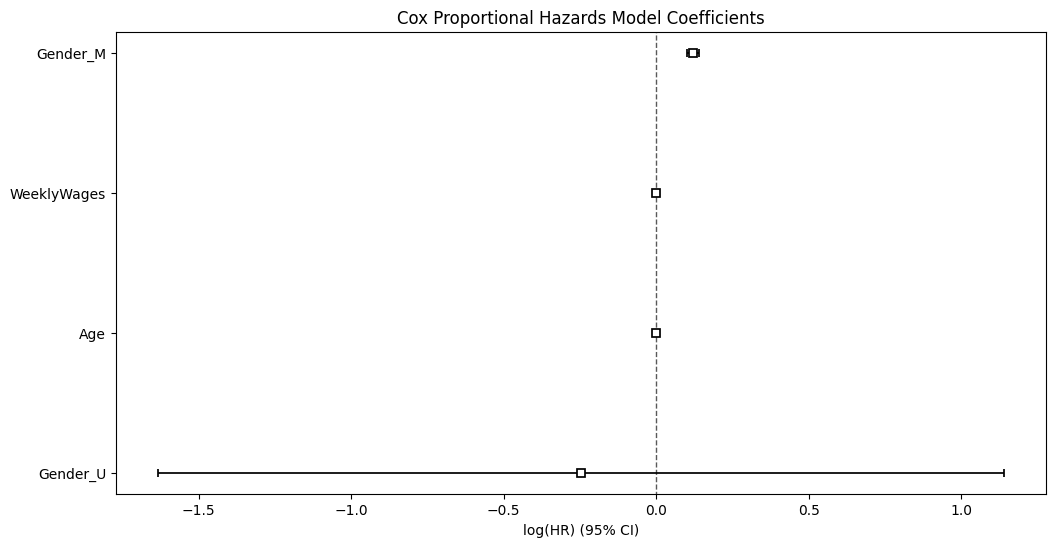

In [217]:
from lifelines import KaplanMeierFitter, CoxPHFitter
df4 = df.copy()
# Create a duration column: time from accident to reporting
df4['Duration'] = (df4['DateReported'] - df4['DateTimeOfAccident']).dt.days


# Create an event column: 1 if reported, 0 if not (assuming all rows are reported for this example)
df4['Event'] = 1

# Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Fit the model
kmf.fit(durations=df4['Duration'], event_observed=df4['Event'])

# Plot the survival function
plt.figure(figsize=(12, 6))
kmf.plot_survival_function()
plt.title('Survival Function: Time to Report Claim')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.show()

# Cox Proportional Hazards Model
## The Cox Proportional Hazards Model output helps you understand the impact of different covariates on the time to an event.


# Select relevant features for Cox model
cox_df = df4[['Duration', 'Event', 'Age', 'Gender', 'WeeklyWages']]
cox_df = pd.get_dummies(cox_df, columns=['Gender'], drop_first=True)

# Initialize and fit the Cox model
cph = CoxPHFitter()
cph.fit(cox_df, duration_col='Duration', event_col='Event')

# Print the summary
cph.print_summary()

# Plot the coefficients
plt.figure(figsize=(12, 6))
cph.plot()
plt.title('Cox Proportional Hazards Model Coefficients')
plt.show()


Descriptive statistics for claims reported within 200 days:
                Age  DependentChildren  DependentsOther   WeeklyWages  \
count  52807.000000            52807.0          52807.0  52807.000000   
mean      33.823546                0.0              0.0    407.201019   
std       12.102815                0.0              0.0    202.065918   
min       13.000000                0.0              0.0      1.000000   
25%       23.000000                0.0              0.0    200.000000   
50%       32.000000                0.0              0.0    393.000000   
75%       43.000000                0.0              0.0    500.000000   
max       73.000000                0.0              0.0    950.000000   

       HoursWorkedPerWeek  DaysWorkedPerWeek  InitialIncurredCalimsCost  \
count        52807.000000            52807.0               52807.000000   
mean            38.354382                5.0                5595.002272   
std              1.725996                0.0             

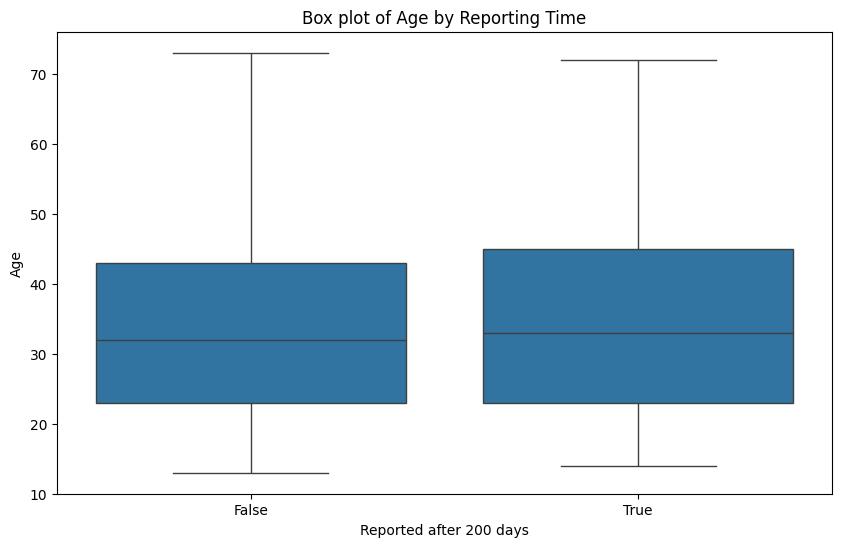

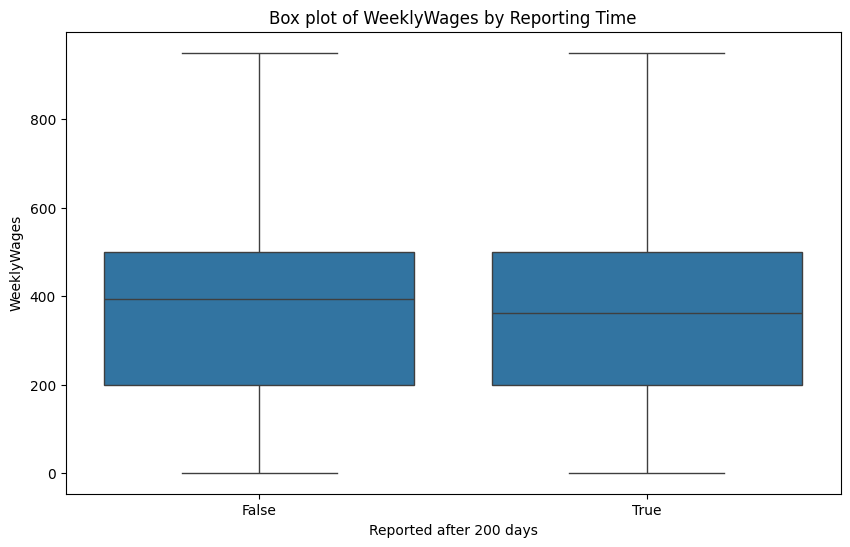

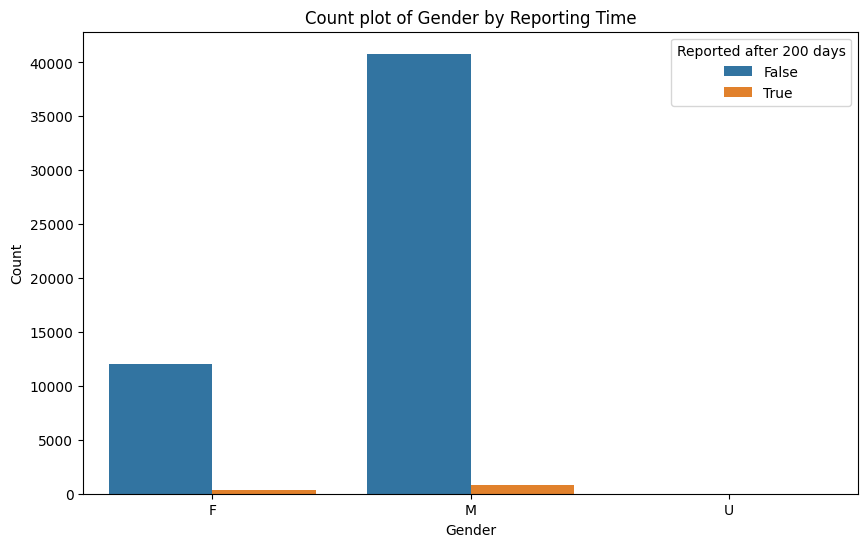

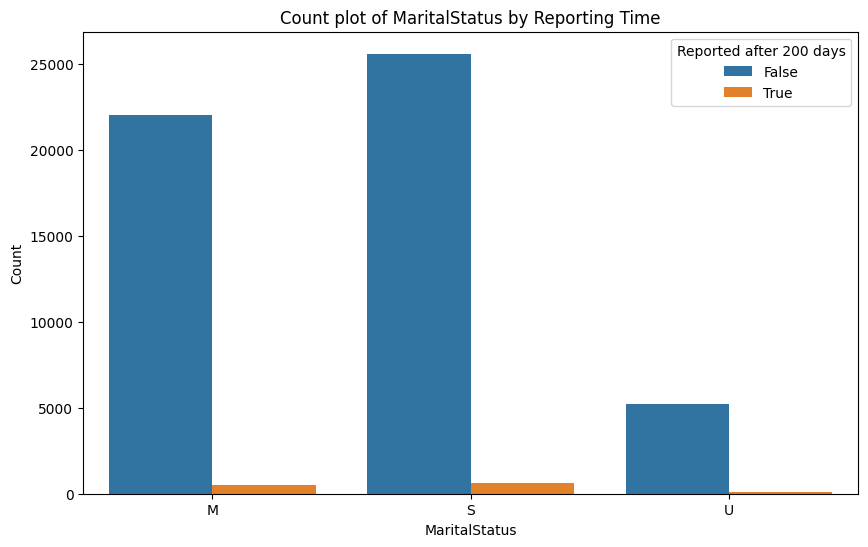

T-test for Age: t-statistic = -2.2458, p-value = 0.0247
T-test for WeeklyWages: t-statistic = 1.4757, p-value = 0.1400
Chi-square test for Gender: chi2 = 25.5419, p-value = 0.0000
Chi-square test for MaritalStatus: chi2 = 3.8005, p-value = 0.1495


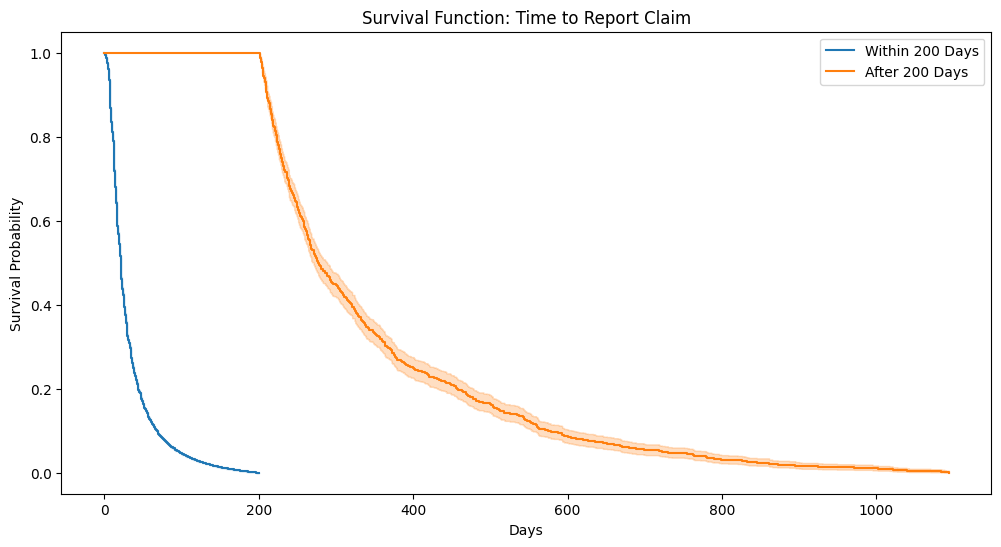

In [225]:
# Segment the data
within_200_days = df4[df4['Duration'] <= 200]
after_200_days = df4[df4['Duration'] > 200]

# Descriptive statistics
print("Descriptive statistics for claims reported within 200 days:")
print(within_200_days.describe())

print("\nDescriptive statistics for claims reported after 200 days:")
print(after_200_days.describe())

# Create a binary column for claims reported after 200 days
df4['Delayed'] = df4['Duration'] > 200

# Box plots for numerical features
numerical_features = ['Age', 'WeeklyWages']

for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Delayed', y=feature, data=df4)
    plt.title(f'Box plot of {feature} by Reporting Time')
    plt.xlabel('Reported after 200 days')
    plt.ylabel(feature)
    plt.show()

# Bar plots for categorical features
categorical_features = ['Gender', 'MaritalStatus']

for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue='Delayed', data=df4)
    plt.title(f'Count plot of {feature} by Reporting Time')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Reported after 200 days')
    plt.show()


# T-tests for numerical features
for feature in numerical_features:
    t_stat, p_val = ttest_ind(within_200_days[feature], after_200_days[feature])
    print(f"T-test for {feature}: t-statistic = {t_stat:.4f}, p-value = {p_val:.4f}")

# Chi-square tests for categorical features
for feature in categorical_features:
    contingency_table = pd.crosstab(df4[feature], df4['Duration'] > 200)
    chi2, p_val, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for {feature}: chi2 = {chi2:.4f}, p-value = {p_val:.4f}")









##The Kaplan-Meier Fitter (KMF) is a non-parametric statistic used to estimate the survival function from lifetime data. It is often used in survival analysis to measure the fraction of subjects living for a certain amount of time after treatment. In the context of your analysis, the KMF model is used to estimate the probability that a claim has not been reported by a certain time after the accident.

##Key Components of KMF
####Survival Function: The probability that a subject (or claim) will survive (or not be reported) beyond a certain time.
####Event: The occurrence of the event of interest, which in this case is the reporting of the claim.
####Duration: The time from the start point (date of accident) to the event (date of report).







# Kaplan-Meier Fitter for the two groups
kmf_within = KaplanMeierFitter()
kmf_after = KaplanMeierFitter()

# Fit the model
kmf_within.fit(durations=within_200_days['Duration'], event_observed=within_200_days['Event'], label='Within 200 Days')
kmf_after.fit(durations=after_200_days['Duration'], event_observed=after_200_days['Event'], label='After 200 Days')

# Plot the survival functions
plt.figure(figsize=(12, 6))
kmf_within.plot_survival_function()
kmf_after.plot_survival_function()
plt.title('Survival Function: Time to Report Claim')
plt.xlabel('Days')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

In [226]:

X = df4[['Age', 'WeeklyWages', 'Gender_M', 'Gender_F', 'MaritalStatus_M', 'MaritalStatus_S', 'MaritalStatus_U']]  # Add other relevant features
y = df4['Delayed']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importances = pd.Series(clf.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(12, 6))
plt.title('Feature Importances')
plt.show()

KeyError: "['Gender_M', 'Gender_F', 'MaritalStatus_M', 'MaritalStatus_S', 'MaritalStatus_U'] not in index"